In [5]:
# import models
# N_trials = 50
# N_universe = 1000
# T = 5000
# models.world_sim(T = T, N_trials = N_trials,\
#                 input_file='leaf.jpg',output_name='big_simulation_data')


In [7]:
import networks
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

load data

In [9]:
angle_right_recording, angle_left_recording, step_intent_recording,\
          step_action_recording, sensor_recording,position_recording,\
            = networks.pull_from_file('many_leaves_simulation_data_thin_skin.npz',ignore_or = True)#'big_simulation_data.npz')
angle_right_recording = angle_right_recording[1:,:]#@ time of decision (intent of next layer)
angle_left_recording = angle_left_recording[1:,:]#@ time of decision (intent of next layer)
step_intent_recording = step_intent_recording[1:,:]#@ time of decision (intent of next layer)
step_action_recording = step_action_recording[:-1,:] #@ time of decision (action of previous layer)
sensor_recording = sensor_recording[:,:-1,:]#@ time of decision (sense of previous layer)
print('angle_right_recording', angle_right_recording.shape)
print('angle_left_recording', angle_left_recording.shape)
print('step_intent_recording', step_intent_recording.shape)
print('step_action_recording', step_action_recording.shape)
print('sensor_recorstep_reshapedding', sensor_recording.shape)
T_test = 16  # length of each subsequence
N_sensors = sensor_recording.shape[0]
N_trials = sensor_recording.shape[2]
factor_train = 0.8


angle_right_recording (7199, 10)
angle_left_recording (7199, 10)
step_intent_recording (7199, 10)
step_action_recording (7199, 10)
sensor_recorstep_reshapedding (64, 7199, 10)


In [25]:
angle_right_subsequences = networks.extract_subsequences(angle_right_recording*2, T_test)
angle_left_subsequences = networks.extract_subsequences(angle_left_recording*2, T_test)
step_intent_subsequences = networks.extract_subsequences(step_intent_recording*0.2, T_test)
step_action_subsequences = networks.extract_subsequences(step_action_recording*0.2, T_test)
sensor_subsequences = networks.extract_subsequences(sensor_recording, T_test,sensor=True)

print(step_action_subsequences.shape, sensor_subsequences.shape)
N_data_points = step_action_subsequences.shape[0]
N_data_train = round(N_data_points*factor_train)
x = np.concatenate([\
    sensor_subsequences, angle_left_subsequences, angle_right_subsequences,\
          step_intent_subsequences, step_action_subsequences], axis=-1)
y = np.concatenate([\
    sensor_subsequences, step_action_subsequences], axis=-1)


print('median',np.median(x[:,:,66]))
print('mean', np.mean(x[:,:,66]))
print('std', np.std(x[:,:,66]))
print('median',np.median(x[:,:,24:40]))
print('mean', np.mean(x[:,:,:24:40]))
print('std', np.std(x[:,:,:24:40]))
shuffled_indices = np.random.permutation(x.shape[0])
x = x[shuffled_indices]
noise = np.random.normal(loc=0.0, scale=0.2, size=x.shape)
x = x + noise
y = y[shuffled_indices]
x_train = x[:50000,:,:]
x_val= x[N_data_train:,:,:]
y_train = y[:50000,:,:]
y_val= y[N_data_train:,:,:]
print('x',x.shape)
print('x train',x_train.shape)
print('x val',x_val.shape)
print('y',y.shape)
print('y train',y_train.shape)
print('y val',y_val.shape)



(71840, 16, 1) (71840, 16, 64)
median 0.6
mean 0.50036603
std 0.30032274
median 0.0
mean 0.011761179
std 0.07559675
x (71840, 16, 68)
x train (50000, 16, 68)
x val (14368, 16, 68)
y (71840, 16, 65)
y train (50000, 16, 65)
y val (14368, 16, 65)


In [27]:

include_motor = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using', DEVICE)
l1_spaced = np.logspace(-7,-5, 5)#10**-5.325
# Dictionary to store losses for each L1 value
aresults = {}
# for l1_val in l1_spaced:
for run_n in range(0,10):
    net = networks.TemporalPrediction(hidden_units=128, L1=1.0*10**-6, device=DEVICE,\
                                    N_sensors=N_sensors, T_test = T_test, include_motor = include_motor)
    net.to(DEVICE)
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
    train_loss_arr = []
    val_loss_arr = []
    val_loss_mse_arr = []
    val_loss_l1_arr = []
    epochs = 10000
    for epoch in tqdm(range(epochs),desc='Simulation'):
        train_temp = []
        val_temp = []
        val_temp_mse = []
        val_temp_l1 = []
        # Train loop
        for clip_past_frames, clip_next_frame in networks.frame_selection(x_train, y_train,\
                                                                            include_motor=include_motor, N_sensors=64,batch_size=10000):  
            optimizer.zero_grad()
            clip_prediction = net(clip_past_frames)
            loss,loss_mse,loss_l1 = net.loss_fn(clip_next_frame, clip_prediction)
            loss.backward()
            optimizer.step()
            train_temp.append(loss.item())   
        # Val loop
        for clip_past_frames, clip_next_frame in networks.frame_selection(x_val, y_val,\
                                                                            include_motor=include_motor, N_sensors=64,batch_size=10000):                                          
            with torch.no_grad():
                clip_prediction = net(clip_past_frames)
                loss,loss_mse,loss_l1 = net.loss_fn(clip_next_frame, clip_prediction)
                val_temp.append(loss.item())      
                val_temp_mse.append(loss_mse.item())   
                val_temp_l1.append(loss_l1.item())   
        train_loss_arr.append(np.mean(train_temp))
        val_loss_arr.append(np.mean(val_temp))   
        val_loss_mse_arr.append(np.mean(val_temp_mse))   
        val_loss_l1_arr.append(np.mean(val_temp_l1))   
    filename = f"unstd_temporal_prediction_model_thin_skin_run{run_n}.pth"
    #torch.save(net.state_dict(), filename)
    #print('Model saved successfully.')
    #formatted_value = f'{l1_val:.1e}'
    #filename = f"temporal_prediction_model_uniform_norm_{formatted_value}_l1.pth"
    torch.save(net.state_dict(), filename)
    print('Model saved successfully.')


    #Store results for this L1 value
    aresults[run_n] = {
        'train_loss': train_loss_arr,
        'val_loss': val_loss_arr,
        'val_mse': val_loss_mse_arr,
        'val_l1': val_loss_l1_arr
    }


Using cuda


Simulation:  14%|█▍        | 1412/10000 [12:32<1:15:34,  1.89it/s]

In [10]:
for i in range(5,8):
    print(i)

5
6
7


In [16]:
include_motor = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using', DEVICE)
l1_spaced = np.logspace(-8,-5,13)#10**-5.325
# Dictionary to store losses for each L1 value
results = {}
net = networks.TemporalPrediction(hidden_units=128, L1=3.2*10**-6, device=DEVICE,\
                                N_sensors=N_sensors, T_test = T_test, include_motor = include_motor)
net.to(DEVICE)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
train_loss_arr = []
val_loss_arr = []
val_loss_mse_arr = []
val_loss_l1_arr = []
epochs = 10000
for epoch in tqdm(range(epochs),desc='Simulation'):
    train_temp = []
    val_temp = []
    val_temp_mse = []
    val_temp_l1 = []
    # Train loop
    for clip_past_frames, clip_next_frame in networks.frame_selection(x_train, y_train,include_motor=include_motor,\
                                                                       N_sensors=64,batch_size=10000):  
        
        optimizer.zero_grad()
        clip_prediction = net(clip_past_frames)
        loss,loss_mse,loss_l1 = net.loss_fn(clip_next_frame, clip_prediction)
        loss.backward()
        optimizer.step()
        train_temp.append(loss.item())   
    # Val loop
    for clip_past_frames, clip_next_frame in networks.frame_selection(x_val, y_val,include_motor=include_motor,\
                                                                       N_sensors=64,batch_size=10000):                                          
        with torch.no_grad():
            clip_prediction = net(clip_past_frames)
            loss,loss_mse,loss_l1 = net.loss_fn(clip_next_frame, clip_prediction)
            val_temp.append(loss.item())      
            val_temp_mse.append(loss_mse.item())   
            val_temp_l1.append(loss_l1.item())   
    train_loss_arr.append(np.mean(train_temp))
    val_loss_arr.append(np.mean(val_temp))   
    val_loss_mse_arr.append(np.mean(val_temp_mse))   
    val_loss_l1_arr.append(np.mean(val_temp_l1))   
# formatted_value = f'{l1_val:.1e}'
filename = "temporal_prediction_model_new_data_normed_386l1.pth"
torch.save(net.state_dict(), filename)
print('Model saved successfully.')

# #Store results for this L1 value
# results[l1_val] = {
#     'train_loss': train_loss_arr,
#     'val_loss': val_loss_arr,
#     'val_mse': val_loss_mse_arr,
#     'val_l1': val_loss_l1_arr
# }


Using cuda


Simulation:   0%|          | 0/10000 [00:00<?, ?it/s]

Simulation: 100%|██████████| 10000/10000 [15:10<00:00, 10.99it/s]

Model saved successfully.


In [200]:

model = networks.TemporalPrediction(hidden_units=128, L1=3.2*10**-6, device=DEVICE, N_sensors=N_sensors, T_test=T_test, include_motor=include_motor)
model.load_state_dict(f'temporal_prediction_model_uniform_norm_1.0e-06_l1.pth')#'temporal_prediction_model_final_setup_6.1e-07_l1.pth'))

model = net
model.to(DEVICE)
hidden_weights = model.hidden.weight.data
hidden_weights = hidden_weights.view(128,T_test-1,N_sensors+4 )
final_sensor_weights = hidden_weights[:,-1,0:64]
final_angle_intent_left_weights = hidden_weights[:,-1,64]
final_angle_intent_right_weights = hidden_weights[:,-1,65]
final_motor_intent_weights = hidden_weights[:,-1,66]
final_motor_action_weights = hidden_weights[:,-1,67]
final_motor_command_weights = hidden_weights[:,-1,64:]
final_sensor_sign = (1*(torch.sum(1.5*hidden_weights[:, :, 0:64], dim=1)<torch.sum(abs(hidden_weights[:, :, 0:64]), dim=1)))
final_motor_command_sign = (1*(torch.sum(1.5*hidden_weights[:, :, 64:], dim=1)<torch.sum(abs(hidden_weights[:, :, 64:]), dim=1)))

sensor_duration = (torch.sum(abs(hidden_weights[:, :, 0:64]), dim=1)/abs(hidden_weights[:, -1, 0:64]))
motor_duration = (torch.sum(abs(hidden_weights[:, :, 64:]), dim=1)/abs(hidden_weights[:, -1, 64:]))






TypeError: Expected state_dict to be dict-like, got <class 'str'>.

In [95]:
import torch
import networks  # Ensure this module is correctly imported


# Initialize tensors as empty lists for dynamic concatenation
final_sensor_weights = []
final_angle_intent_left_weights = []
final_angle_intent_right_weights = []
final_motor_intent_weights = []
penultimate_motor_intent_weights = []
final_motor_action_weights = []
final_motor_command_weights = []
final_sensor_sign = []
final_motor_command_sign = []
sensor_duration = []
motor_duration = []
sensor_integrativity = []
motor_integrativity = []

# Iterate over the models
for run_n in range(10):
    # Filename for each model
    filename = f"mleaves_temporal_prediction_model_thin_skin_run{run_n}.pth"
    # filename = f"normal_temporal_prediction_model_thin_skin_run{run_n}.pth"
    
    # Initialize the model
    model = networks.TemporalPrediction(hidden_units=128, L1=3.2e-6, device=DEVICE, N_sensors=N_sensors, T_test=T_test, include_motor=include_motor)
    
    # Load model weights
    model.load_state_dict(torch.load(filename))
    model.to(DEVICE)
    
    # Process hidden weights
    hidden_weights = model.hidden.weight.data
    hidden_weights = hidden_weights.view(128, T_test-1, N_sensors+4)
    
    # Extract weights and append to the corresponding lists
    final_sensor_weights.append(hidden_weights[:, -1, 0:64])
    final_angle_intent_left_weights.append(hidden_weights[:, -1, 64])
    final_angle_intent_right_weights.append(hidden_weights[:, -1, 65])
    final_motor_intent_weights.append(hidden_weights[:, -1, 66])
    penultimate_motor_intent_weights.append(hidden_weights[:, -1, 66])
    final_motor_action_weights.append(hidden_weights[:, -1, 67])
    final_motor_command_weights.append(hidden_weights[:, -1, 64:])

    # final_sensor_sign.append(1*((2*abs(torch.sum(hidden_weights[:, :, 0:64], dim=1)))<(torch.sum(abs(hidden_weights[:, :, 0:64]), dim=1))))
    # final_motor_command_sign.append(1*((2*abs(torch.sum(hidden_weights[:, :, 64:], dim=1)))<(torch.sum(abs(hidden_weights[:, :, 64:]), dim=1))))
    final_sensor_sign.append(1*(torch.sum(hidden_weights[:, :-1, 0:64], dim=1) + hidden_weights[:, -1, 0:64] < 0))
    final_motor_command_sign.append(1*(torch.sum(hidden_weights[:, :-1, 64:], dim=1) + hidden_weights[:, -1, 64:] < 0))

    sensor_duration.append(torch.sum(abs(hidden_weights[:, :, 0:64]), dim=1)/abs(hidden_weights[:, -1, 0:64]))
    motor_duration.append(torch.sum(abs(hidden_weights[:, :, 64:]), dim=1)/abs(hidden_weights[:, -1, 64:]))

    sensor_integrativity.append(torch.sum(abs(hidden_weights[:, :, 0:64]), dim=1)/abs(torch.sum(hidden_weights[:, :, 0:64], dim=1)))
    motor_integrativity.append(torch.sum(abs(hidden_weights[:, :, 64:]), dim=1)/abs(torch.sum(hidden_weights[:, :, 64:], dim=1)))




# Convert lists to tensors by concatenation along the desired dimension
final_sensor_weights = torch.cat(final_sensor_weights, dim=0)
final_angle_intent_left_weights = torch.cat(final_angle_intent_left_weights, dim=0)
final_angle_intent_right_weights = torch.cat(final_angle_intent_right_weights, dim=0)
final_motor_intent_weights = torch.cat(final_motor_intent_weights, dim=0)
final_motor_action_weights = torch.cat(final_motor_action_weights, dim=0)
final_motor_command_weights = torch.cat(final_motor_command_weights, dim=0)
final_sensor_sign = torch.cat(final_sensor_sign, dim=0)
final_motor_command_sign = torch.cat(final_motor_command_sign, dim=0)
sensor_duration = torch.cat(sensor_duration, dim=0)
motor_duration = torch.cat(motor_duration, dim=0)
sensor_integrativity = torch.cat(sensor_integrativity, dim=0)
motor_integrativity = torch.cat(motor_integrativity, dim=0)


# At this point, you have tensors that have grown in size with each run, where each tensor's first dimension is the concatenation of runs
print("Collected and concatenated weights from all runs.")


Collected and concatenated weights from all runs.


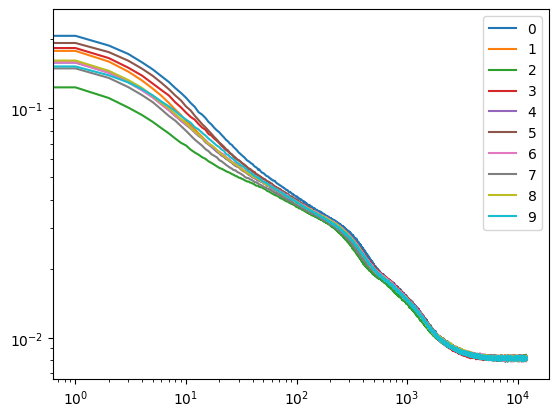

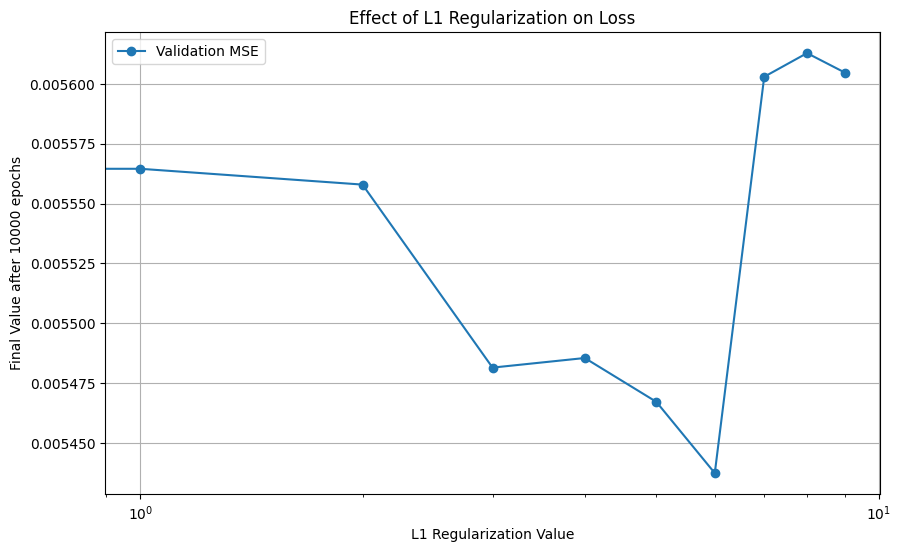

[3.16227766e-08 8.48342898e-08 2.27584593e-07 6.10540230e-07
 1.63789371e-06 4.39397056e-06 1.17876863e-05 3.16227766e-05]


In [60]:
import matplotlib.pyplot as plt

# # Assuming `results` is populated as per the previous example
# final_val_MSE = [data['val_mse'][-1] for l1_value, data in sorted(results.items())]
# l1_values = sorted(results.keys())
# final_val_losses = [data['val_loss'][-1] for l1_value, data in sorted(results.items())]
# final_train_losses = [data['train_loss'][-1] for l1_value, data in sorted(results.items())]
# Assuming `results` is populated as per the previous example
final_val_MSE = [data['val_mse'][-1] for l1_value, data in sorted(aresults.items())]
l1_values = sorted(results.keys())
final_val_losses = [data['val_loss'][:] for l1_value, data in sorted(aresults.items())]
final_train_losses = [data['train_loss'][:] for l1_value, data in sorted(aresults.items())]

# print(np.shape(final_val_losses))
plt.figure()
plt.plot(range(12000), np.array(final_val_losses).transpose(),label  = l1_values)
plt.legend()
plt.xscale('log')
plt.yscale('log')

# # Plotting the final validation loss against L1 values
plt.figure(figsize=(10, 6))
#plt.plot(l1_values, final_val_losses, marker='o', linestyle='-',label='Validation loss')
plt.plot(l1_values, final_val_MSE, marker='o', linestyle='-',label='Validation MSE')

#plt.plot(l1_values, final_train_losses, marker='o', linestyle='-',label='Training loss')
a = 7
#plt.plot([8.25*10**-a,8.25*10**-a],[0.02,0.025])
plt.xscale('log')  # Since L1 values are on a logarithmic scale
plt.xlabel('L1 Regularization Value')
plt.ylabel('Final Value after 10000 epochs')
plt.title('Effect of L1 Regularization on Loss')
plt.legend()
plt.grid(True)
plt.show()
print(np.logspace(-7.5,-4.5,8))

/tmp/ipykernel_20254/3149085146.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('seismic')  # 'bwr' stands for Blue-White-Red but will adjust to Blue-Black-Red using norm


torch.Size([128, 15, 68])
image size torch.Size([15, 68])


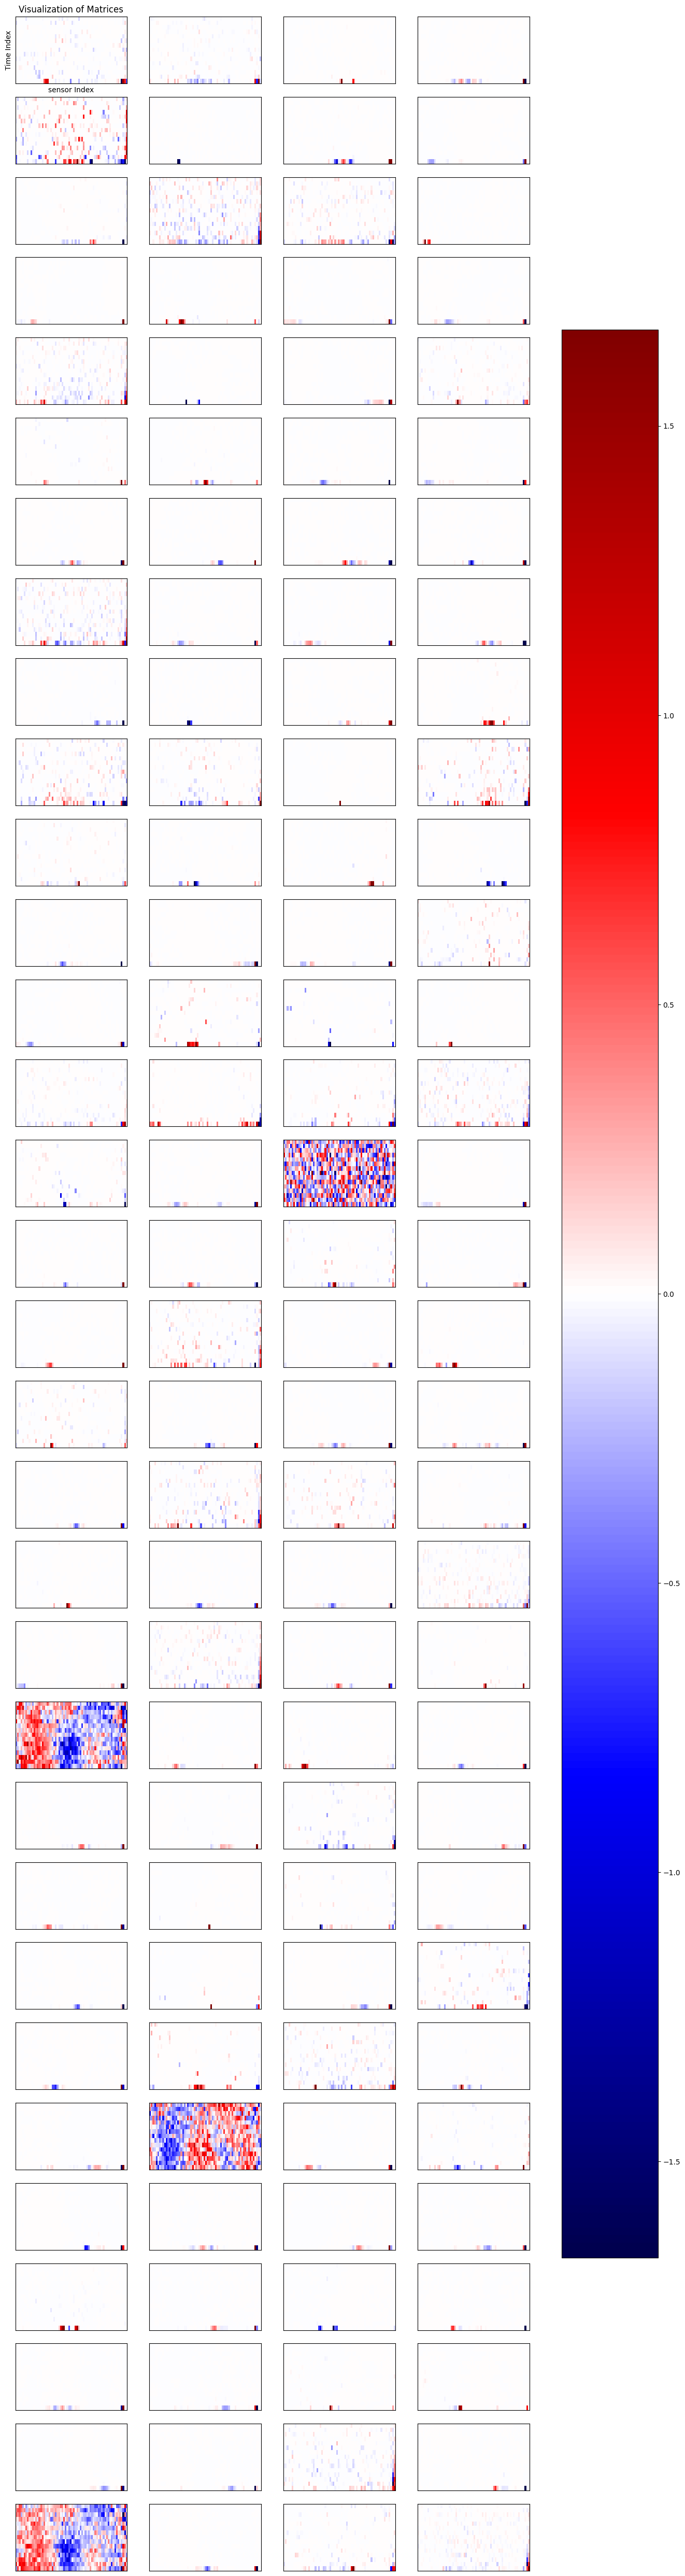

In [96]:

# model = networks.TemporalPrediction(hidden_units=128, L1=3.2*10**-6, device=DEVICE, N_sensors=N_sensors, T_test=T_test, include_motor=include_motor)
# model.load_state_dict(torch.load('temporal_prediction_model_uniform_norm_3.2e-06_l1.pth'))
# model.to(DEVICE)
# hidden_weights = model.hidden.weight.data
# hidden_weights = hidden_weights.view(128,T_test-1,N_sensors+4 )
# final_sensor_weights = hidden_weights[:,-1,0:64]
# final_angle_intent_left_weights = hidden_weights[:,-1,64]
# final_angle_intent_right_weights = hidden_weights[:,-1,65]
# final_motor_intent_weights = hidden_weights[:,-1,66]
# final_motor_action_weights = hidden_weights[:,-1,67]
# final_motor_command_weights = hidden_weights[:,-1,64:]
# final_sensor_sign = (1*(torch.sum(1.5*hidden_weights[:, :, 0:64], dim=1)<torch.sum(abs(hidden_weights[:, :, 0:64]), dim=1)))
# final_motor_command_sign = (1*(torch.sum(1.5*hidden_weights[:, :, 64:], dim=1)<torch.sum(abs(hidden_weights[:, :, 64:]), dim=1)))

# sensor_duration = (torch.sum(abs(hidden_weights[:, :, 0:64]), dim=1)/abs(hidden_weights[:, -1, 0:64]))
# motor_duration = (torch.sum(abs(hidden_weights[:, :, 64:]), dim=1)/abs(hidden_weights[:, -1, 64:]))




import matplotlib.pyplot as plt
import torch
from matplotlib.colors import TwoSlopeNorm
from matplotlib import cm
from matplotlib.colors import SymLogNorm

sensor_edges = np.linspace(-np.pi, np.pi, 64)
cmap = cm.get_cmap('seismic')  # 'bwr' stands for Blue-White-Red but will adjust to Blue-Black-Red using norm



print(hidden_weights.shape)
global_scale =False
vmax = torch.max(abs(hidden_weights))
vmin = -vmax
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
fig, axes = plt.subplots(32, 4, figsize=(16, 64))  # Adjust figsize as needed
for i in range(32):
    for j in range(4):
        index = i * 4 + j  # Correct indexing over a flat list of weights        
        if include_motor == True:
            #image_matrix = h0.reshape((T_test - 1,N_sensors+4))
            image_matrix = hidden_weights[index,:,:].view(T_test-1,N_sensors+4).cpu()
        else:
            image_matrix = hidden_weights[index,:,:].view(T_test-1,N_sensors).cpu()
        ax = axes[i, j]
        if global_scale == False:
            vmax = torch.max(abs(image_matrix))
            vmin = -vmax
            norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
            # norm = LogNorm(vmin=vmin, vmax=vmax)
            #norm = SymLogNorm(linthresh=0.01, vmin=vmin, vmax=vmax, base=10)

        # a = image_matrix>=0
        # b = image_matrix<0
        # image_matrix[a] = np.log(image_matrix[a])
        # image_matrix[b] = -np.log(-image_matrix[b])
        #im = ax.imshow(image_matrix, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
            
        im = ax.imshow(image_matrix[:,:], cmap=cmap, aspect='auto', norm=norm)
        
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0 and j == 0:
            ax.set_title('Visualization of Matrices')
            ax.set_ylabel('Time Index')
            ax.set_xlabel('sensor Index')
print('image size',image_matrix.shape )
fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical')
plt.show()




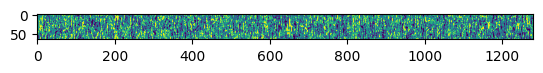

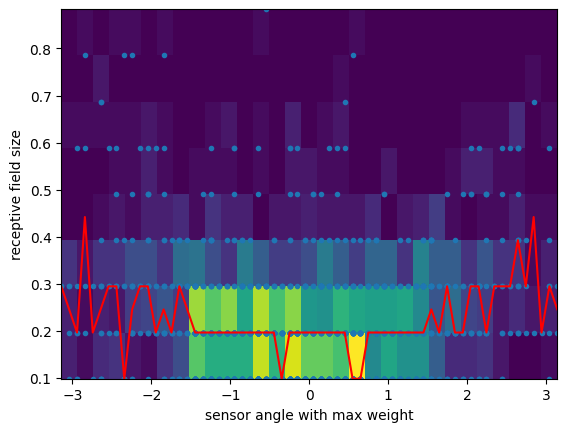

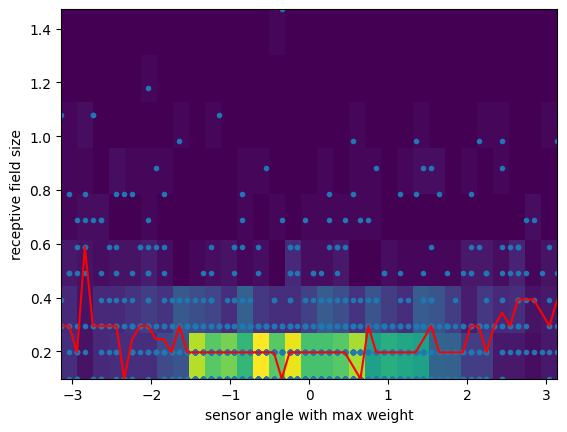

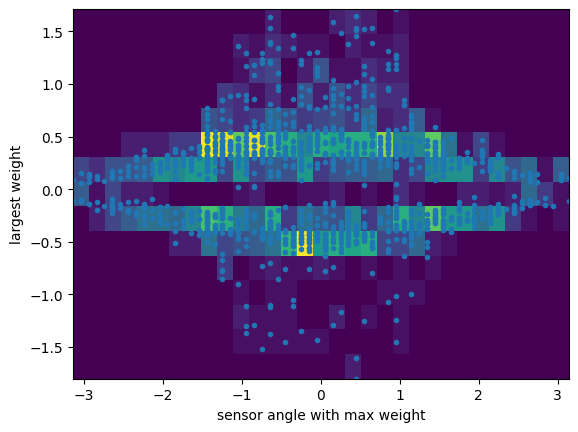

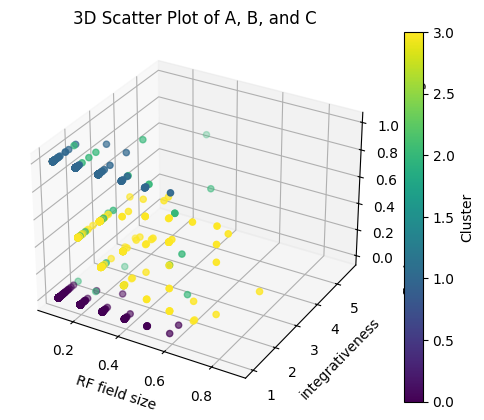

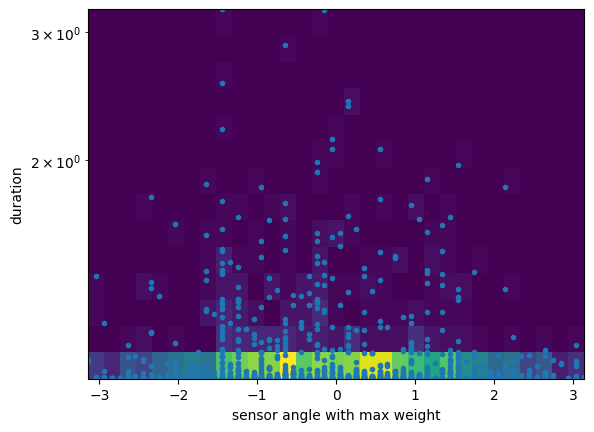

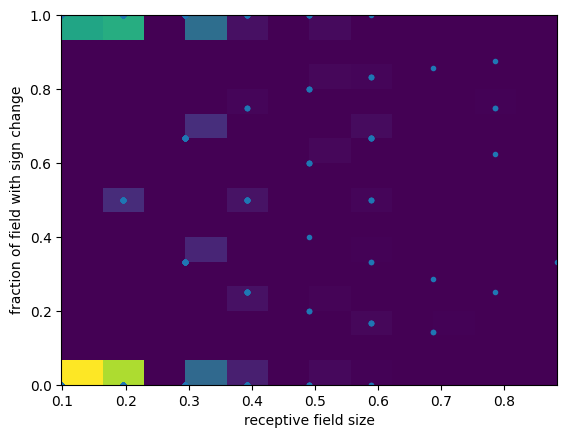

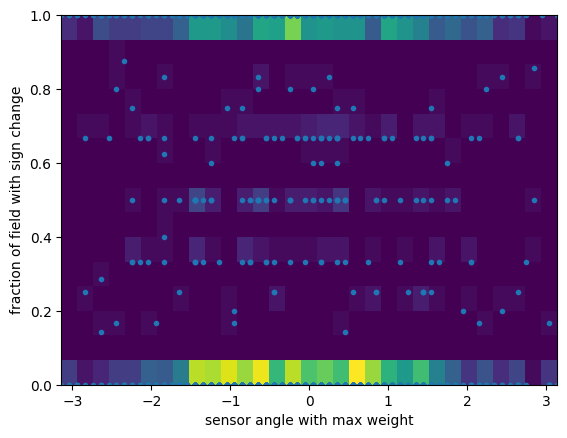

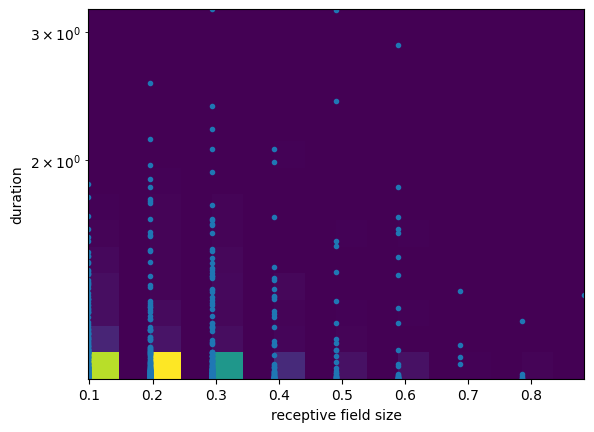

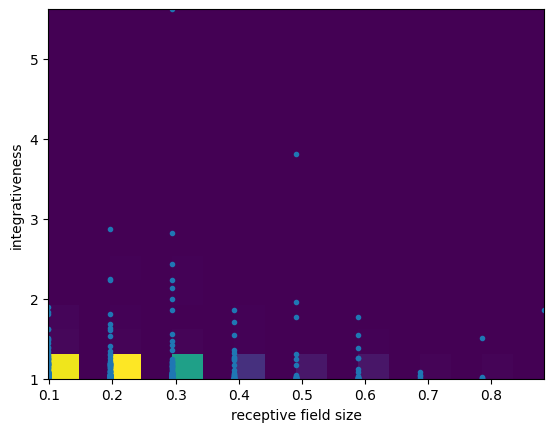

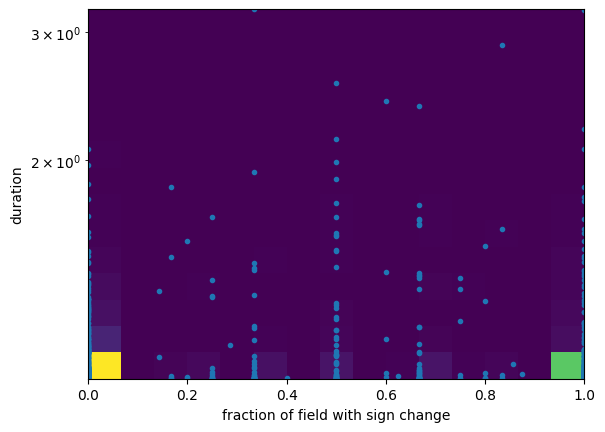

In [105]:
from matplotlib.colors import LogNorm 
import pandas as pd
from scipy.stats import linregress
from mpl_toolkits.mplot3d import Axes3D
weights_plot = final_sensor_weights.cpu().detach().numpy()
weights_plot = np.transpose(weights_plot)
m_weights_plot = final_motor_command_weights.cpu().detach().numpy()
m_weights_plot = np.transpose(m_weights_plot)
duration_plot = sensor_duration.cpu().detach().numpy()
duration_plot = np.transpose(duration_plot)
int_plot = sensor_integrativity.cpu().detach().numpy()
int_plot = np.transpose(int_plot)
sign_plot = final_sensor_sign.cpu().detach().numpy()
sign_plot = np.transpose(sign_plot)
plt.figure()
plt.imshow(sign_plot)

area_weighted = np.empty((6,weights_plot.shape[1])) 
area_weighted[:,:] = np.nan

for i in range(weights_plot.shape[1]):  # Loop through each signal
    signal = weights_plot[:, i]

    abs_signal = signal**2
    weighted_min = max(abs_signal)*0.5
    area_weighted[1,i] = 2*np.pi*sum(abs_signal>weighted_min)/signal.shape[0]
    area_weighted[0,i] = sensor_edges[np.argmax(abs_signal)]
    
    area_weighted[2,i] = duration_plot[np.argmax(abs_signal), i]
    area_weighted[3,i] = sum(sign_plot[(abs_signal>weighted_min), i])/sum(abs_signal>weighted_min)
    area_weighted[4,i] = signal[np.argmax(abs_signal)]
    area_weighted[5,i] = int_plot[np.argmax(abs_signal), i]




N_bins_field_size = 16
N_bins_angle = 32
N_bins_duration = 15
N_bins_motor = 15
N_bins_other = 15
field_size_bins = N_bins_field_size#np.linspace(0, 1*np.pi, N_bins_field_size)#np.logspace(np.log10(2*np.pi/64),np.log10(1*np.pi),N_bins_field_size)#
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[2, :])& (abs(area_weighted[4, :])>0.01)
duration_bins = np.logspace(np.log10(np.min(area_weighted[2, valid_indices])), np.log10(np.max(area_weighted[2, valid_indices])), N_bins_duration)
angle_bins = np.linspace(-np.pi, np.pi, N_bins_angle)

plt.figure()
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[1, :])& (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[0, valid_indices],area_weighted[1, valid_indices], bins= [angle_bins,8])
plt.scatter(area_weighted[0, valid_indices],area_weighted[1, valid_indices],marker = '.')
df = pd.DataFrame({'x': area_weighted[0, valid_indices], 'y': area_weighted[1, valid_indices]})
median_y_per_x = df.groupby('x')['y'].median().reset_index()
plt.plot(median_y_per_x['x'], median_y_per_x['y'],color='red')
plt.xlabel('sensor angle with max weight')
plt.ylabel('receptive field size')
plt.figure()
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[1, :])
plt.hist2d(area_weighted[0, valid_indices],area_weighted[1, valid_indices], bins= [angle_bins,8])
plt.scatter(area_weighted[0, valid_indices],area_weighted[1, valid_indices],marker = '.')
df = pd.DataFrame({'x': area_weighted[0, valid_indices], 'y': area_weighted[1, valid_indices]})
median_y_per_x = df.groupby('x')['y'].median().reset_index()
plt.plot(median_y_per_x['x'], median_y_per_x['y'],color='red')
plt.xlabel('sensor angle with max weight')
plt.ylabel('receptive field size')
#plt.yscale('log')

#plt.ylim((0,1*np.pi))
plt.xlim(-np.pi,np.pi)

plt.figure()
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[4, :])& (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[0, valid_indices],area_weighted[4, valid_indices], bins= [angle_bins,N_bins_other])
plt.scatter(area_weighted[0, valid_indices],area_weighted[4, valid_indices],marker = '.')
plt.xlabel('sensor angle with max weight')
plt.ylabel('largest weight')
plt.xlim(-np.pi,np.pi)


from sklearn.cluster import KMeans



y_data_log = area_weighted[2, valid_indices]#np.log(area_weighted[2, valid_indices])
X = np.vstack((area_weighted[1, valid_indices], y_data_log, area_weighted[3, valid_indices])).T
kmeans = KMeans(n_clusters=4)  # Adjust the number of clusters as necessary
kmeans.fit(X)
clusters = kmeans.labels_
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(area_weighted[1, valid_indices], area_weighted[5, valid_indices], area_weighted[3, valid_indices], c=clusters, cmap='viridis')
plt.colorbar(scatter, ax=ax, label='Cluster')
ax.set_xlabel('RF field size')
ax.set_ylabel('integrativeness')

ax.set_zlabel('Fration of field with sign change')
ax.set_title('3D Scatter Plot of A, B, and C')







#

plt.figure()
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[2, :])& (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[0, valid_indices],area_weighted[2, valid_indices],bins=[angle_bins, duration_bins])
plt.scatter(area_weighted[0, valid_indices],area_weighted[2, valid_indices],marker='.')
plt.xlabel('sensor angle with max weight')
plt.ylabel('duration')
plt.yscale('log') 
plt.xlim(-np.pi,np.pi)

N_bins = 15
plt.figure()
valid_indices = ~np.isnan(area_weighted[1, :]) & ~np.isnan(area_weighted[3, :])& (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[1, valid_indices],area_weighted[3, valid_indices], bins= [12, N_bins_other])
plt.scatter(area_weighted[1, valid_indices],area_weighted[3, valid_indices],marker = '.')
# plt.xlim((0,1*np.pi))
plt.xlabel('receptive field size')
plt.ylabel('fraction of field with sign change')

N_bins = 15
plt.figure()
valid_indices = ~np.isnan(area_weighted[1, :]) & ~np.isnan(area_weighted[3, :])& (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[0, valid_indices],area_weighted[3, valid_indices], bins= [angle_bins, N_bins_other])
plt.scatter(area_weighted[0, valid_indices],area_weighted[3, valid_indices],marker = '.')
# plt.xlim((0,1*np.pi))
plt.xlabel('sensor angle with max weight')
plt.ylabel('fraction of field with sign change')


N_bins = 15
plt.figure()
valid_indices = ~np.isnan(area_weighted[1, :]) & ~np.isnan(area_weighted[3, :])& (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[1, valid_indices],area_weighted[2, valid_indices],bins=[field_size_bins, duration_bins])
plt.scatter(area_weighted[1, valid_indices],area_weighted[2, valid_indices],marker = '.')
plt.xlabel('receptive field size')
plt.ylabel('duration')
plt.yscale('log') 

N_bins = 15
plt.figure()
valid_indices = ~np.isnan(area_weighted[1, :]) & ~np.isnan(area_weighted[3, :])& (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[1, valid_indices],area_weighted[5, valid_indices],bins=[field_size_bins, N_bins_other])
plt.scatter(area_weighted[1, valid_indices],area_weighted[5, valid_indices],marker = '.')
plt.xlabel('receptive field size')
plt.ylabel('integrativeness')



N_bins = 15
plt.figure()
valid_indices = ~np.isnan(area_weighted[1, :]) & ~np.isnan(area_weighted[3, :]) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[3, valid_indices],area_weighted[2, valid_indices],bins=[N_bins_other, duration_bins])
plt.scatter(area_weighted[3, valid_indices],area_weighted[2, valid_indices],marker = '.')
plt.xlabel('fraction of field with sign change')
plt.ylabel('duration')
plt.yscale('log') 




Text(0.5, 1.0, 'rear left')

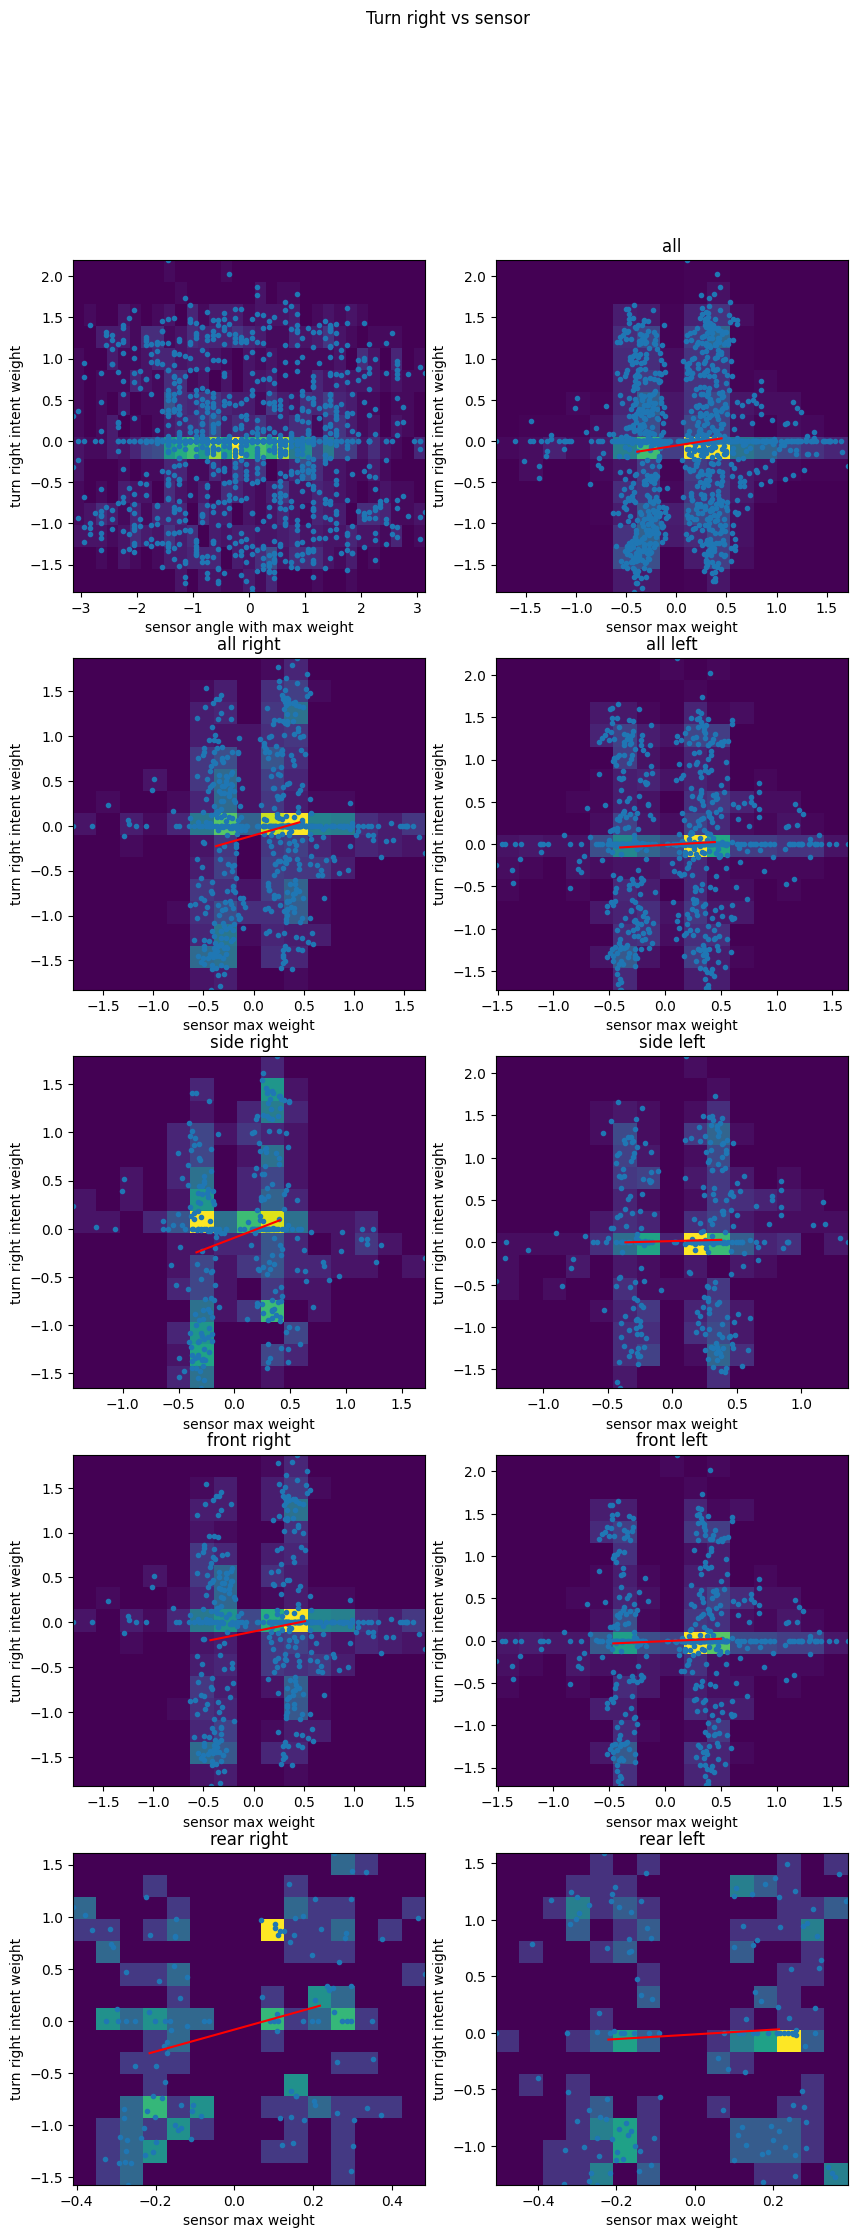

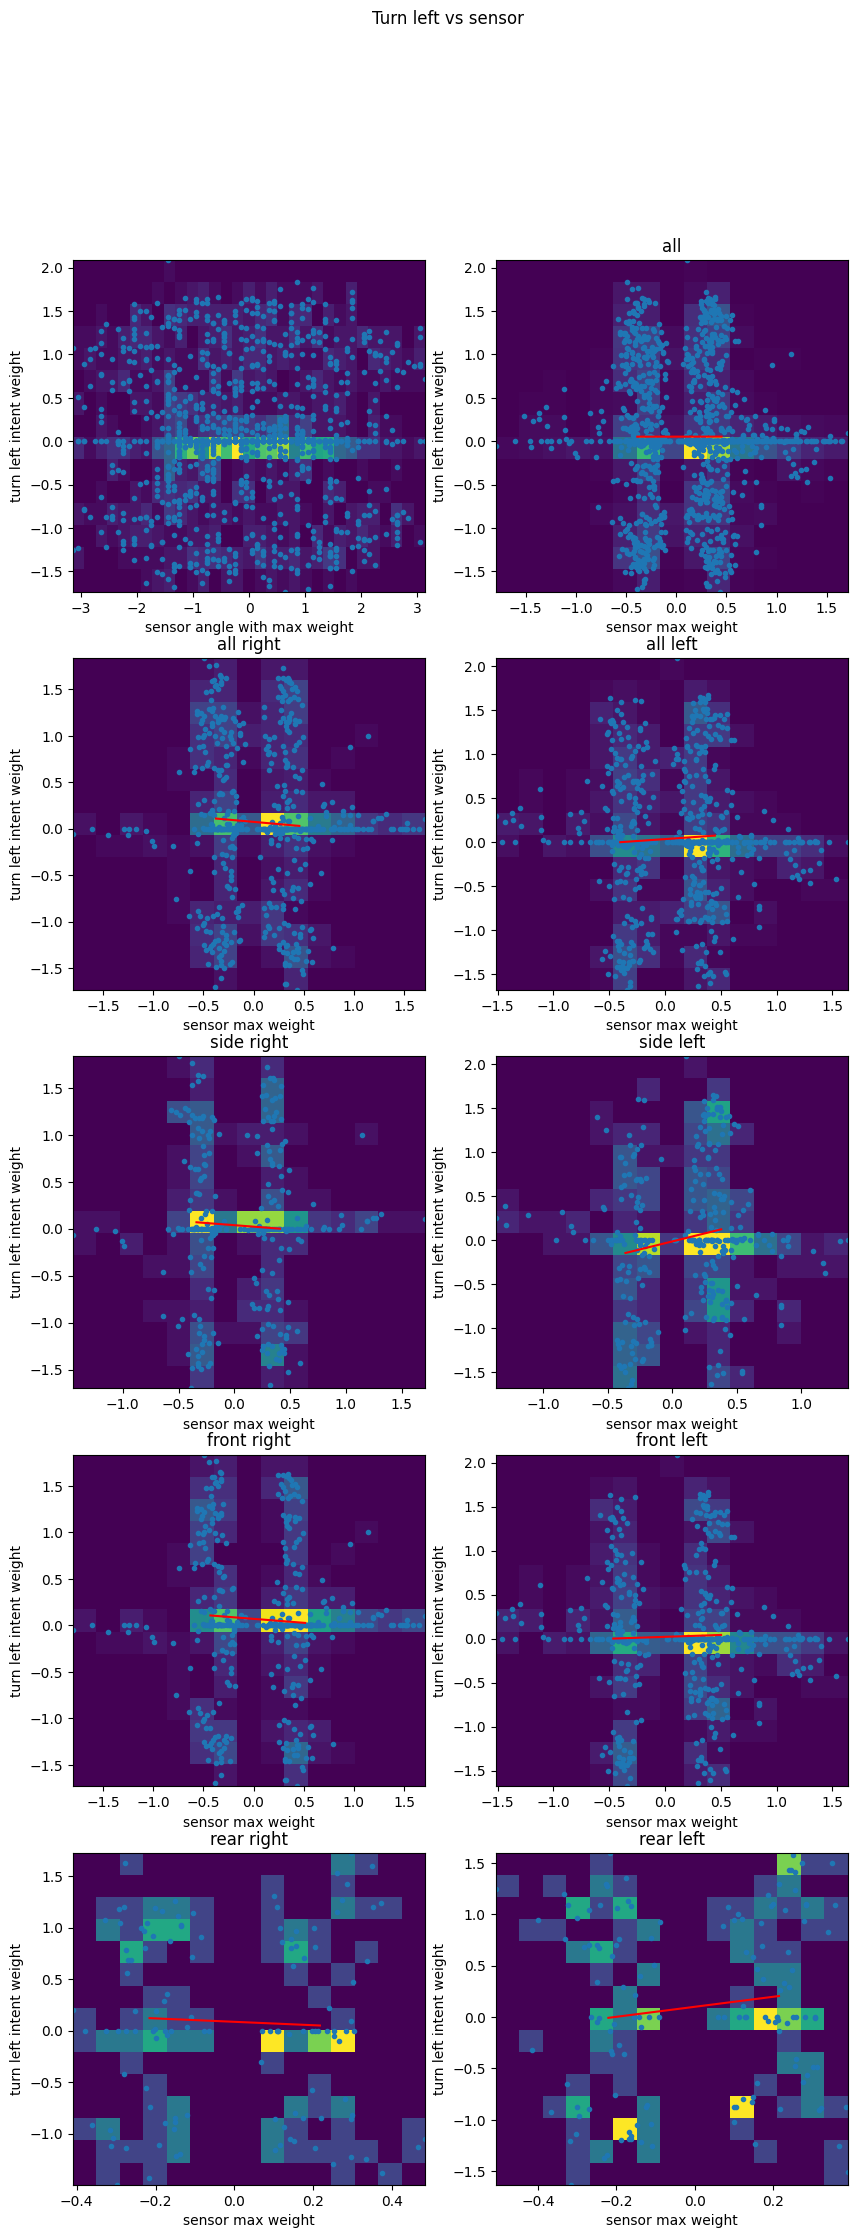

In [102]:
def calculate_means(x_data, y_data):
    # Convert lists to numpy arrays if they aren't already
    x_data = np.array(x_data)
    y_data = np.array(y_data)

    # Filter and calculate means for x > 0
    positive_x_indices = x_data > 0
    x_mean_positive = np.mean(x_data[positive_x_indices])
    y_mean_positive = np.mean(y_data[positive_x_indices])

    # Filter and calculate means for x < 0
    negative_x_indices = x_data < 0
    x_mean_negative = np.mean(x_data[negative_x_indices])
    y_mean_negative = np.mean(y_data[negative_x_indices])

    # Return results as a tuple of lists
    x_vals = [x_mean_negative, x_mean_positive]
    y_vals = [y_mean_negative, y_mean_positive]

    return x_vals, y_vals




plt.figure(figsize=(10,25))
plt.suptitle('Turn right vs sensor')
plt.subplot(5,2,1)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])& (abs(area_weighted[4, :])>0.01)

plt.hist2d(area_weighted[0, valid_indices],m_weights_plot[1,valid_indices], bins= [angle_bins,N_bins_other])
plt.scatter(area_weighted[0, valid_indices],m_weights_plot[1,valid_indices],marker = '.')
plt.xlabel('sensor angle with max weight')
plt.ylabel('turn right intent weight')
plt.xlim(-np.pi,np.pi)
plt.subplot(5,2,2)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])& (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices],marker = '.')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices])
plt.plot(a,b,color = 'red')
plt.xlabel('sensor max weight')
plt.ylabel('turn right intent weight')
plt.title('all')
plt.subplot(5,2,3)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & (area_weighted[0, :]> 0) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices],marker = '.')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices])
plt.plot(a,b,color = 'red')
plt.xlabel('sensor max weight')
plt.ylabel('turn right intent weight')
plt.title('all right')
plt.subplot(5,2,4)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & (area_weighted[0, :]< 0) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices],marker = '.')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices])
plt.plot(a,b,color = 'red')
plt.xlabel('sensor max weight')
plt.ylabel('turn right intent weight')
plt.title('all left')
plt.subplot(5,2,5)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & (area_weighted[0, :]> np.pi/4) & (area_weighted[0, :]<3*np.pi/4) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices],marker = '.')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices])
plt.plot(a,b,color = 'red')
plt.xlabel('sensor max weight')
plt.ylabel('turn right intent weight')
plt.title('side right')
plt.subplot(5,2,6)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & (area_weighted[0, :]< - np.pi/4)  & (area_weighted[0, :]>-3*np.pi/4) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices],marker = '.')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices])
plt.plot(a,b,color = 'red')
plt.xlabel('sensor max weight')
plt.ylabel('turn right intent weight')
plt.title('side left')
plt.subplot(5,2,7)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & (area_weighted[0, :]> 0) & (area_weighted[0, :]<2*np.pi/4) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices],marker = '.')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices])
plt.plot(a,b,color = 'red')
plt.xlabel('sensor max weight')
plt.ylabel('turn right intent weight')
plt.title('front right')
plt.subplot(5,2,8)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & (area_weighted[0, :]< 0)  & (area_weighted[0, :]>-2*np.pi/4) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices],marker = '.')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices])
plt.plot(a,b,color = 'red')
plt.xlabel('sensor max weight')
plt.ylabel('turn right intent weight')
plt.title('front left')
plt.subplot(5,2,9)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & (area_weighted[0, :]> 2*np.pi/4) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices],marker = '.')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices])
plt.plot(a,b,color = 'red')
plt.xlabel('sensor max weight')
plt.ylabel('turn right intent weight')
plt.title('rear right')
plt.subplot(5,2,10)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & (area_weighted[0, :]< - 2*np.pi/4)  & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices],marker = '.')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices])
plt.plot(a,b,color = 'red')
plt.xlabel('sensor max weight')
plt.ylabel('turn right intent weight')
plt.title('rear left')


plt.figure(figsize=(10,25))
plt.suptitle('Turn left vs sensor')
plt.subplot(5,2,1)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])& (abs(area_weighted[4, :])>0.01)

plt.hist2d(area_weighted[0, valid_indices],m_weights_plot[0,valid_indices], bins= [angle_bins,N_bins_other])
plt.scatter(area_weighted[0, valid_indices],m_weights_plot[0,valid_indices],marker = '.')
plt.xlabel('sensor angle with max weight')
plt.ylabel('turn left intent weight')
plt.xlim(-np.pi,np.pi)
plt.subplot(5,2,2)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])& (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices],marker = '.')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices])
plt.plot(a,b,color = 'red')
plt.xlabel('sensor max weight')
plt.ylabel('turn left intent weight')
plt.title('all')
plt.subplot(5,2,3)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & (area_weighted[0, :]> 0) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices],marker = '.')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices])
plt.plot(a,b,color = 'red')
plt.xlabel('sensor max weight')
plt.ylabel('turn left intent weight')
plt.title('all right')
plt.subplot(5,2,4)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & (area_weighted[0, :]< 0) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices],marker = '.')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices])
plt.plot(a,b,color = 'red')
plt.xlabel('sensor max weight')
plt.ylabel('turn left intent weight')
plt.title('all left')
plt.subplot(5,2,5)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & (area_weighted[0, :]> np.pi/4) & (area_weighted[0, :]<3*np.pi/4) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices],marker = '.')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices])
plt.plot(a,b,color = 'red')
plt.xlabel('sensor max weight')
plt.ylabel('turn left intent weight')
plt.title('side right')
plt.subplot(5,2,6)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & (area_weighted[0, :]< - np.pi/4)  & (area_weighted[0, :]>-3*np.pi/4) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices],marker = '.')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices])
plt.plot(a,b,color = 'red')
plt.xlabel('sensor max weight')
plt.ylabel('turn left intent weight')
plt.title('side left')
plt.subplot(5,2,7)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & (area_weighted[0, :]> 0) & (area_weighted[0, :]<2*np.pi/4) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices],marker = '.')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices])
plt.plot(a,b,color = 'red')
plt.xlabel('sensor max weight')
plt.ylabel('turn left intent weight')
plt.title('front right')
plt.subplot(5,2,8)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & (area_weighted[0, :]< 0)  & (area_weighted[0, :]>-2*np.pi/4) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices],marker = '.')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices])
plt.plot(a,b,color = 'red')
plt.xlabel('sensor max weight')
plt.ylabel('turn left intent weight')
plt.title('front left')
plt.subplot(5,2,9)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & (area_weighted[0, :]> 2*np.pi/4) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices],marker = '.')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices])
plt.plot(a,b,color = 'red')
plt.xlabel('sensor max weight')
plt.ylabel('turn left intent weight')
plt.title('rear right')
plt.subplot(5,2,10)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & (area_weighted[0, :]< - 2*np.pi/4)  & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices],marker = '.')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[0,valid_indices])
plt.plot(a,b,color = 'red')
plt.xlabel('sensor max weight')
plt.ylabel('turn left intent weight')
plt.title('rear left')

Text(0.5, 1.0, 'Sides, P-value: 2.6021e-02')

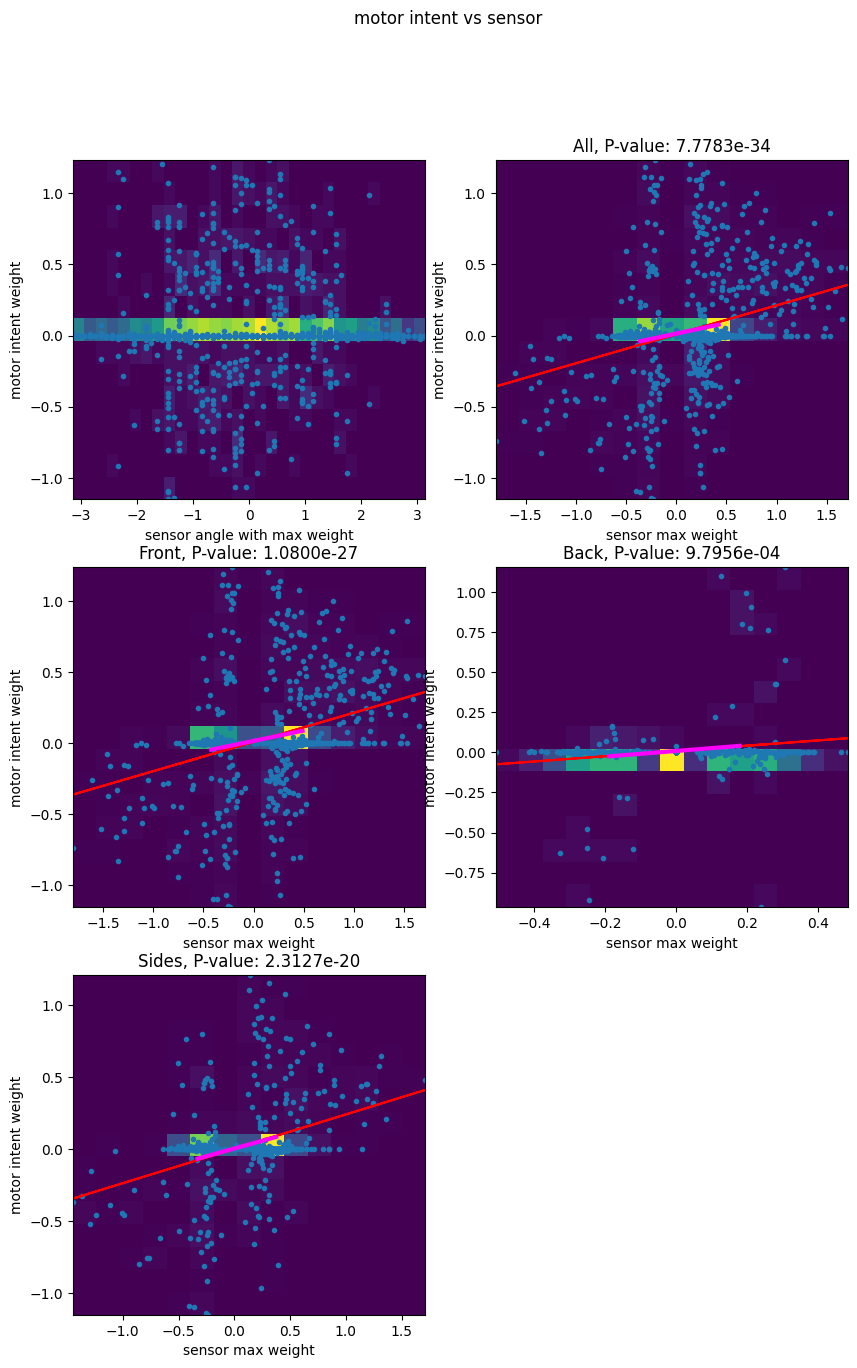

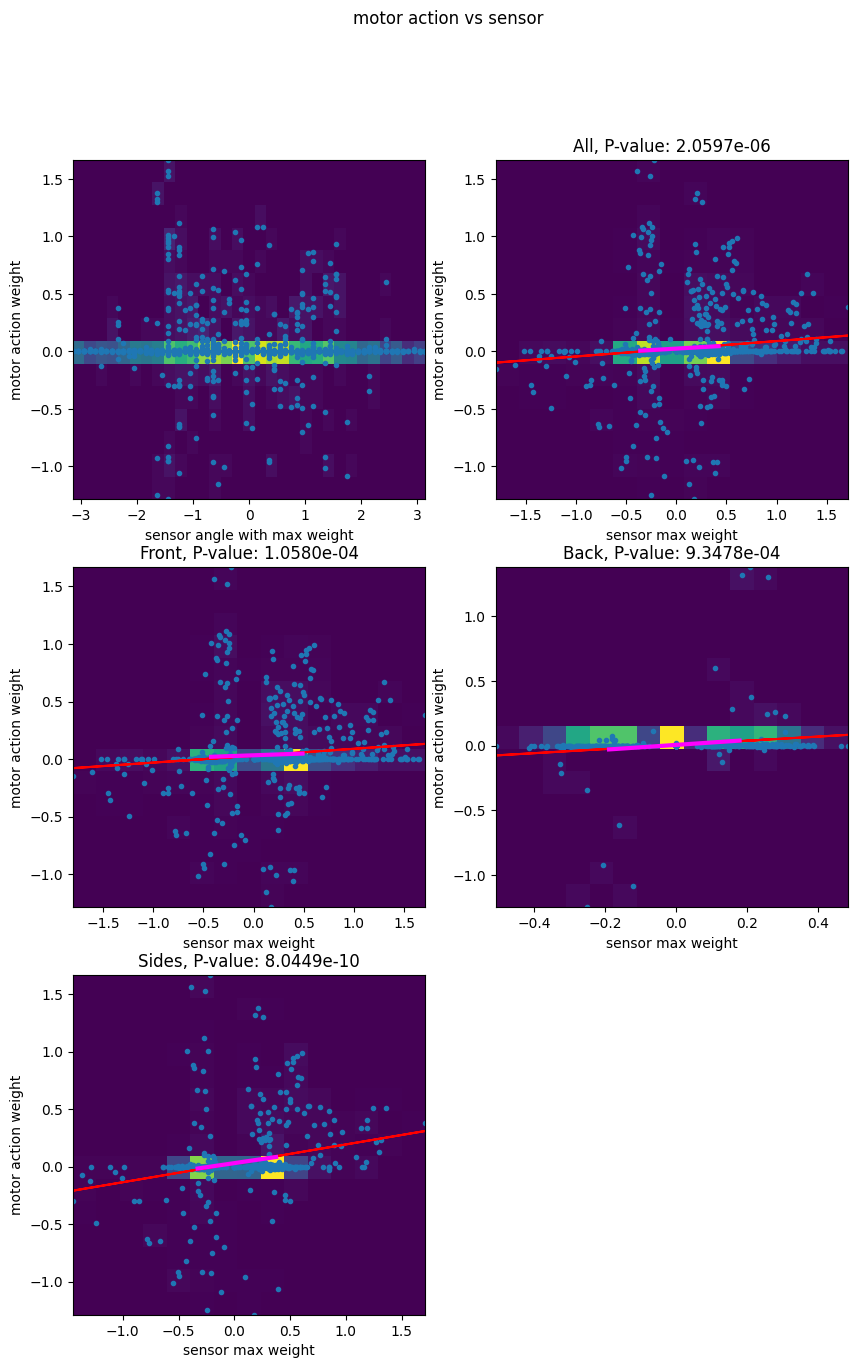

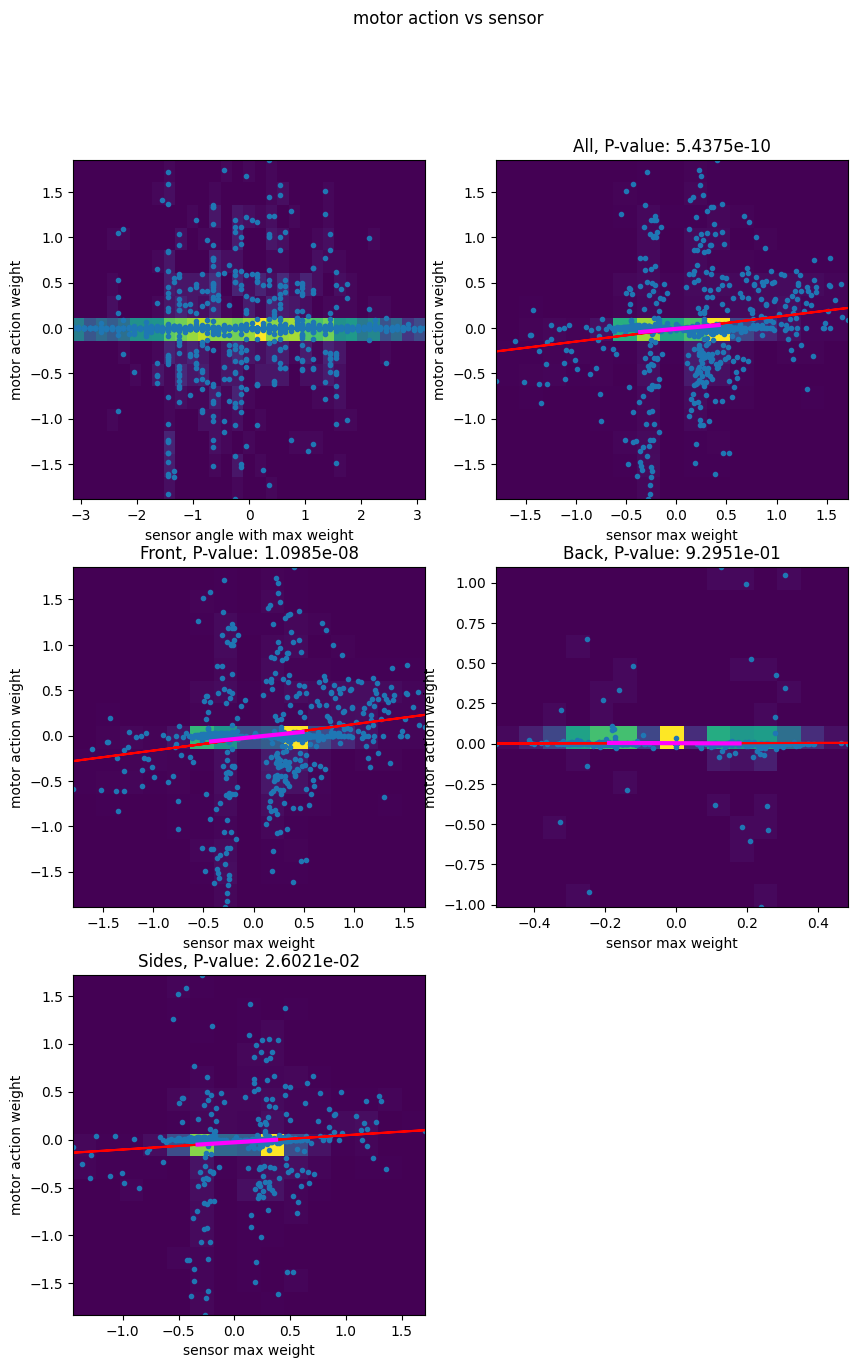

In [99]:

# & (abs(area_weighted[4, :])>0.01)

plt.figure(figsize=(10,15))
plt.suptitle('motor intent vs sensor')
plt.subplot(3,2,1)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])
plt.hist2d(area_weighted[0, valid_indices],m_weights_plot[2,valid_indices], bins= [angle_bins,N_bins_other])
plt.scatter(area_weighted[0, valid_indices],m_weights_plot[2,valid_indices],marker = '.')
plt.xlabel('sensor angle with max weight')
plt.ylabel('motor intent weight')
plt.xlim(-np.pi,np.pi)
plt.subplot(3,2,2)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices],marker = '.')
slope, intercept, r_value, p_value, std_err = linregress(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices])
line = slope * area_weighted[4, valid_indices] + intercept
plt.plot(area_weighted[4, valid_indices], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices])
plt.plot(a,b,color = 'magenta', linewidth = 3)
plt.xlabel('sensor max weight')
plt.ylabel('motor intent weight')
plt.title(f'All, P-value: {p_value:.4e}')
plt.subplot(3,2,3)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & (area_weighted[0, :]<np.pi/2) & (area_weighted[0, :]>-np.pi/2)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices],marker = '.')
slope, intercept, r_value, p_value, std_err = linregress(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices])
line = slope * area_weighted[4, valid_indices] + intercept
plt.plot(area_weighted[4, valid_indices], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices])
plt.plot(a,b,color = 'magenta', linewidth = 3)
plt.xlabel('sensor max weight')
plt.ylabel('motor intent weight')
plt.title(f'Front, P-value: {p_value:.4e}')
plt.subplot(3,2,4)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & (area_weighted[0, :]>2*np.pi/4) | (area_weighted[0, :]<-2*np.pi/4)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices],marker = '.')
slope, intercept, r_value, p_value, std_err = linregress(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices])
line = slope * area_weighted[4, valid_indices] + intercept
plt.plot(area_weighted[4, valid_indices], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices])
plt.plot(a,b,color = 'magenta', linewidth = 3)
plt.xlabel('sensor max weight')
plt.ylabel('motor intent weight')
plt.title(f'Back, P-value: {p_value:.4e}')
plt.subplot(3,2,5)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & ~(((area_weighted[0, :]<np.pi/4) & (area_weighted[0, :]>-np.pi/4)) \
          |  ((area_weighted[0, :]>3*np.pi/4) | (area_weighted[0, :]<-3*np.pi/4)))
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices],marker = '.')
slope, intercept, r_value, p_value, std_err = linregress(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices])
line = slope * area_weighted[4, valid_indices] + intercept
plt.plot(area_weighted[4, valid_indices], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices])
plt.plot(a,b,color = 'magenta', linewidth = 3)
plt.xlabel('sensor max weight')
plt.ylabel('motor intent weight')
plt.title(f'Sides, P-value: {p_value:.4e}')

plt.figure(figsize=(10,15))
plt.suptitle('motor action vs sensor')
plt.subplot(3,2,1)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])
plt.hist2d(area_weighted[0, valid_indices],m_weights_plot[3,valid_indices], bins= [angle_bins,N_bins_other])
plt.scatter(area_weighted[0, valid_indices],m_weights_plot[3,valid_indices],marker = '.')
plt.xlabel('sensor angle with max weight')
plt.ylabel('motor action weight')
plt.xlim(-np.pi,np.pi)
plt.subplot(3,2,2)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices],marker = '.')
slope, intercept, r_value, p_value, std_err = linregress(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices])
line = slope * area_weighted[4, valid_indices] + intercept
plt.plot(area_weighted[4, valid_indices], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices])
plt.plot(a,b,color = 'magenta', linewidth = 3)
plt.xlabel('sensor max weight')
plt.ylabel('motor action weight')
plt.title(f'All, P-value: {p_value:.4e}')
plt.subplot(3,2,3)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & (area_weighted[0, :]<np.pi/2) & (area_weighted[0, :]>-np.pi/2)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices],marker = '.')
slope, intercept, r_value, p_value, std_err = linregress(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices])
line = slope * area_weighted[4, valid_indices] + intercept
plt.plot(area_weighted[4, valid_indices], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices])
plt.plot(a,b,color = 'magenta', linewidth = 3)
plt.xlabel('sensor max weight')
plt.ylabel('motor action weight')
plt.title(f'Front, P-value: {p_value:.4e}')
plt.subplot(3,2,4)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & (area_weighted[0, :]>2*np.pi/4) | (area_weighted[0, :]<-2*np.pi/4)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices],marker = '.')
slope, intercept, r_value, p_value, std_err = linregress(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices])
line = slope * area_weighted[4, valid_indices] + intercept
plt.plot(area_weighted[4, valid_indices], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices])
plt.plot(a,b,color = 'magenta', linewidth = 3)
plt.xlabel('sensor max weight')
plt.ylabel('motor action weight')
plt.title(f'Back, P-value: {p_value:.4e}')
plt.subplot(3,2,5)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & ~(((area_weighted[0, :]<np.pi/4) & (area_weighted[0, :]>-np.pi/4)) \
          |  ((area_weighted[0, :]>3*np.pi/4) | (area_weighted[0, :]<-3*np.pi/4)))
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices],marker = '.')
slope, intercept, r_value, p_value, std_err = linregress(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices])
line = slope * area_weighted[4, valid_indices] + intercept
plt.plot(area_weighted[4, valid_indices], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices])
plt.plot(a,b,color = 'magenta', linewidth = 3)
plt.xlabel('sensor max weight')
plt.ylabel('motor action weight')
plt.title(f'Sides, P-value: {p_value:.4e}')




plt.figure(figsize=(10,15))
plt.suptitle('motor action vs sensor')
plt.subplot(3,2,1)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])
plt.hist2d(area_weighted[0, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices], bins= [angle_bins,N_bins_other])
plt.scatter(area_weighted[0, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices],marker = '.')
plt.xlabel('sensor angle with max weight')
plt.ylabel('motor action weight')
plt.xlim(-np.pi,np.pi)
plt.subplot(3,2,2)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices],marker = '.')
slope, intercept, r_value, p_value, std_err = linregress(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices])
line = slope * area_weighted[4, valid_indices] + intercept
plt.plot(area_weighted[4, valid_indices], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices])
plt.plot(a,b,color = 'magenta', linewidth = 3)
plt.xlabel('sensor max weight')
plt.ylabel('motor action weight')
plt.title(f'All, P-value: {p_value:.4e}')
plt.subplot(3,2,3)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & (area_weighted[0, :]<np.pi/2) & (area_weighted[0, :]>-np.pi/2)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices],marker = '.')
slope, intercept, r_value, p_value, std_err = linregress(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices])
line = slope * area_weighted[4, valid_indices] + intercept
plt.plot(area_weighted[4, valid_indices], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices])
plt.plot(a,b,color = 'magenta', linewidth = 3)
plt.xlabel('sensor max weight')
plt.ylabel('motor action weight')
plt.title(f'Front, P-value: {p_value:.4e}')
plt.subplot(3,2,4)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & (area_weighted[0, :]>2*np.pi/4) | (area_weighted[0, :]<-2*np.pi/4)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices],marker = '.')
slope, intercept, r_value, p_value, std_err = linregress(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices])
line = slope * area_weighted[4, valid_indices] + intercept
plt.plot(area_weighted[4, valid_indices], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices])
plt.plot(a,b,color = 'magenta', linewidth = 3)
plt.xlabel('sensor max weight')
plt.ylabel('motor action weight')
plt.title(f'Back, P-value: {p_value:.4e}')
plt.subplot(3,2,5)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & ~(((area_weighted[0, :]<np.pi/4) & (area_weighted[0, :]>-np.pi/4)) \
          |  ((area_weighted[0, :]>3*np.pi/4) | (area_weighted[0, :]<-3*np.pi/4)))
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices],marker = '.')
slope, intercept, r_value, p_value, std_err = linregress(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices])
line = slope * area_weighted[4, valid_indices] + intercept
plt.plot(area_weighted[4, valid_indices], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices])
plt.plot(a,b,color = 'magenta', linewidth = 3)
plt.xlabel('sensor max weight')
plt.ylabel('motor action weight')
plt.title(f'Sides, P-value: {p_value:.4e}')



Text(0.5, 1.0, 'Sides, P-value: 2.8811e-02')

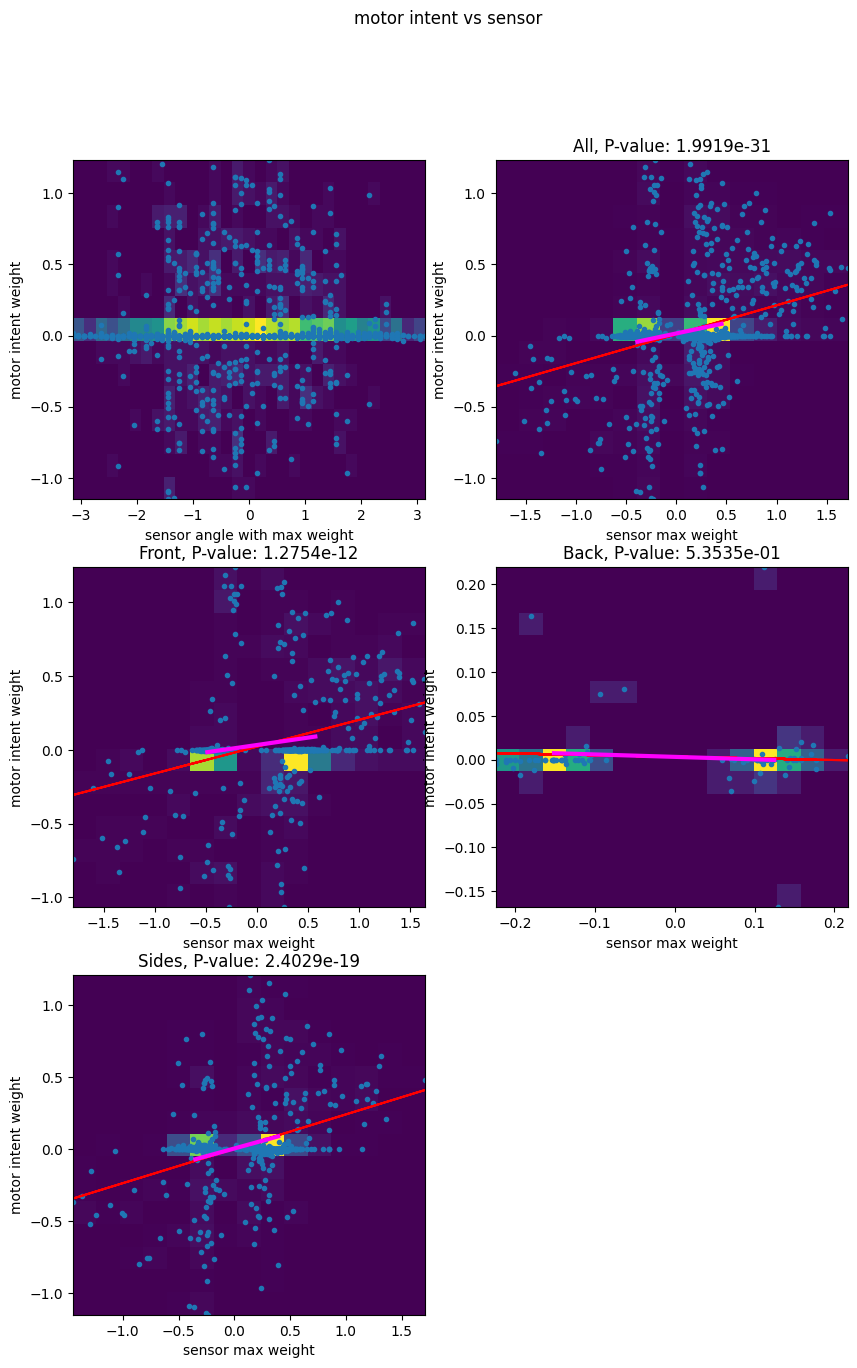

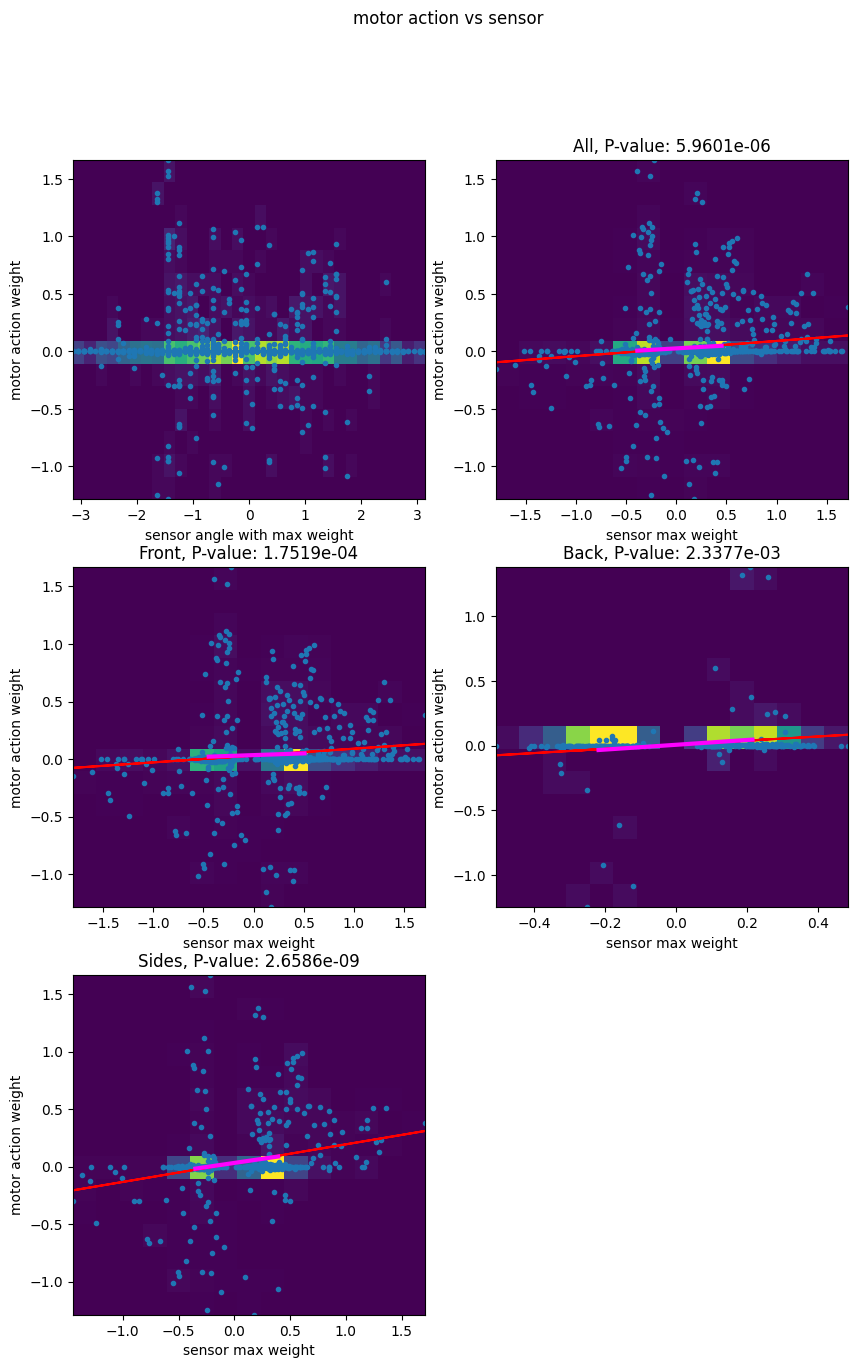

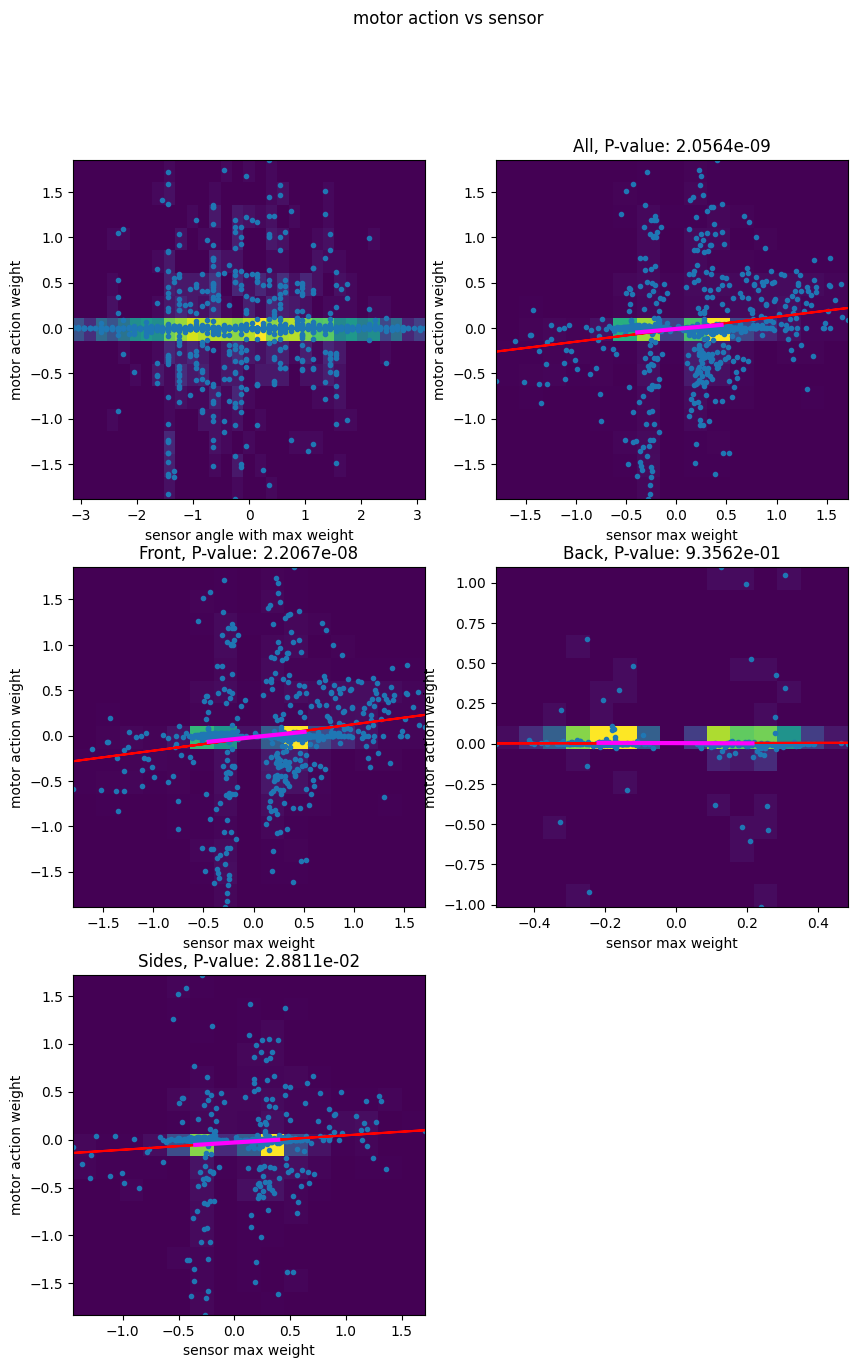

In [101]:

# & (abs(area_weighted[4, :])>0.01)

plt.figure(figsize=(10,15))
plt.suptitle('motor intent vs sensor')
plt.subplot(3,2,1)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])& (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[0, valid_indices],m_weights_plot[2,valid_indices], bins= [angle_bins,N_bins_other])
plt.scatter(area_weighted[0, valid_indices],m_weights_plot[2,valid_indices],marker = '.')
plt.xlabel('sensor angle with max weight')
plt.ylabel('motor intent weight')
plt.xlim(-np.pi,np.pi)
plt.subplot(3,2,2)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])& (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices],marker = '.')
slope, intercept, r_value, p_value, std_err = linregress(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices])
line = slope * area_weighted[4, valid_indices] + intercept
plt.plot(area_weighted[4, valid_indices], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices])
plt.plot(a,b,color = 'magenta', linewidth = 3)
plt.xlabel('sensor max weight')
plt.ylabel('motor intent weight')
plt.title(f'All, P-value: {p_value:.4e}')
plt.subplot(3,2,3)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & (area_weighted[0, :]<np.pi/4) & (area_weighted[0, :]>-np.pi/4)& (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices],marker = '.')
slope, intercept, r_value, p_value, std_err = linregress(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices])
line = slope * area_weighted[4, valid_indices] + intercept
plt.plot(area_weighted[4, valid_indices], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices])
plt.plot(a,b,color = 'magenta', linewidth = 3)
plt.xlabel('sensor max weight')
plt.ylabel('motor intent weight')
plt.title(f'Front, P-value: {p_value:.4e}')
plt.subplot(3,2,4)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & ((area_weighted[0, :]>3*np.pi/4) | (area_weighted[0, :]<-3*np.pi/4)) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices],marker = '.')
slope, intercept, r_value, p_value, std_err = linregress(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices])
line = slope * area_weighted[4, valid_indices] + intercept
plt.plot(area_weighted[4, valid_indices], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices])
plt.plot(a,b,color = 'magenta', linewidth = 3)
plt.xlabel('sensor max weight')
plt.ylabel('motor intent weight')
plt.title(f'Back, P-value: {p_value:.4e}')
plt.subplot(3,2,5)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & ~(((area_weighted[0, :]<np.pi/4) & (area_weighted[0, :]>-np.pi/4)) \
          |  ((area_weighted[0, :]>3*np.pi/4) | (area_weighted[0, :]<-3*np.pi/4))) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices],marker = '.')
slope, intercept, r_value, p_value, std_err = linregress(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices])
line = slope * area_weighted[4, valid_indices] + intercept
plt.plot(area_weighted[4, valid_indices], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices])
plt.plot(a,b,color = 'magenta', linewidth = 3)
plt.xlabel('sensor max weight')
plt.ylabel('motor intent weight')
plt.title(f'Sides, P-value: {p_value:.4e}')

plt.figure(figsize=(10,15))
plt.suptitle('motor action vs sensor')
plt.subplot(3,2,1)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :]) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[0, valid_indices],m_weights_plot[3,valid_indices], bins= [angle_bins,N_bins_other])
plt.scatter(area_weighted[0, valid_indices],m_weights_plot[3,valid_indices],marker = '.')
plt.xlabel('sensor angle with max weight')
plt.ylabel('motor action weight')
plt.xlim(-np.pi,np.pi)
plt.subplot(3,2,2)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :]) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices],marker = '.')
slope, intercept, r_value, p_value, std_err = linregress(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices])
line = slope * area_weighted[4, valid_indices] + intercept
plt.plot(area_weighted[4, valid_indices], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices])
plt.plot(a,b,color = 'magenta', linewidth = 3)
plt.xlabel('sensor max weight')
plt.ylabel('motor action weight')
plt.title(f'All, P-value: {p_value:.4e}')
plt.subplot(3,2,3)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & (area_weighted[0, :]<np.pi/2) & (area_weighted[0, :]>-np.pi/2) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices],marker = '.')
slope, intercept, r_value, p_value, std_err = linregress(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices])
line = slope * area_weighted[4, valid_indices] + intercept
plt.plot(area_weighted[4, valid_indices], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices])
plt.plot(a,b,color = 'magenta', linewidth = 3)
plt.xlabel('sensor max weight')
plt.ylabel('motor action weight')
plt.title(f'Front, P-value: {p_value:.4e}')
plt.subplot(3,2,4)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & ((area_weighted[0, :]>2*np.pi/4) | (area_weighted[0, :]<-2*np.pi/4)) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices],marker = '.')
slope, intercept, r_value, p_value, std_err = linregress(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices])
line = slope * area_weighted[4, valid_indices] + intercept
plt.plot(area_weighted[4, valid_indices], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices])
plt.plot(a,b,color = 'magenta', linewidth = 3)
plt.xlabel('sensor max weight')
plt.ylabel('motor action weight')
plt.title(f'Back, P-value: {p_value:.4e}')
plt.subplot(3,2,5)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & ~(((area_weighted[0, :]<np.pi/4) & (area_weighted[0, :]>-np.pi/4)) \
          |  ((area_weighted[0, :]>3*np.pi/4) | (area_weighted[0, :]<-3*np.pi/4))) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices],marker = '.')
slope, intercept, r_value, p_value, std_err = linregress(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices])
line = slope * area_weighted[4, valid_indices] + intercept
plt.plot(area_weighted[4, valid_indices], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[3,valid_indices])
plt.plot(a,b,color = 'magenta', linewidth = 3)
plt.xlabel('sensor max weight')
plt.ylabel('motor action weight')
plt.title(f'Sides, P-value: {p_value:.4e}')




plt.figure(figsize=(10,15))
plt.suptitle('motor action vs sensor')
plt.subplot(3,2,1)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :]) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[0, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices], bins= [angle_bins,N_bins_other])
plt.scatter(area_weighted[0, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices],marker = '.')
plt.xlabel('sensor angle with max weight')
plt.ylabel('motor action weight')
plt.xlim(-np.pi,np.pi)
plt.subplot(3,2,2)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :]) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices],marker = '.')
slope, intercept, r_value, p_value, std_err = linregress(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices])
line = slope * area_weighted[4, valid_indices] + intercept
plt.plot(area_weighted[4, valid_indices], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices])
plt.plot(a,b,color = 'magenta', linewidth = 3)
plt.xlabel('sensor max weight')
plt.ylabel('motor action weight')
plt.title(f'All, P-value: {p_value:.4e}')
plt.subplot(3,2,3)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & (area_weighted[0, :]<np.pi/2) & (area_weighted[0, :]>-np.pi/2) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices],marker = '.')
slope, intercept, r_value, p_value, std_err = linregress(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices])
line = slope * area_weighted[4, valid_indices] + intercept
plt.plot(area_weighted[4, valid_indices], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices])
plt.plot(a,b,color = 'magenta', linewidth = 3)
plt.xlabel('sensor max weight')
plt.ylabel('motor action weight')
plt.title(f'Front, P-value: {p_value:.4e}')
plt.subplot(3,2,4)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & ((area_weighted[0, :]>2*np.pi/4) | (area_weighted[0, :]<-2*np.pi/4)) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices],marker = '.')
slope, intercept, r_value, p_value, std_err = linregress(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices])
line = slope * area_weighted[4, valid_indices] + intercept
plt.plot(area_weighted[4, valid_indices], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices])
plt.plot(a,b,color = 'magenta', linewidth = 3)
plt.xlabel('sensor max weight')
plt.ylabel('motor action weight')
plt.title(f'Back, P-value: {p_value:.4e}')
plt.subplot(3,2,5)
valid_indices = ~np.isnan(area_weighted[0, :]) & ~np.isnan(area_weighted[0, :])\
      & ~(((area_weighted[0, :]<np.pi/4) & (area_weighted[0, :]>-np.pi/4)) \
          |  ((area_weighted[0, :]>3*np.pi/4) | (area_weighted[0, :]<-3*np.pi/4))) & (abs(area_weighted[4, :])>0.01)
plt.hist2d(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices], bins= [N_bins_other,N_bins_other])
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices],marker = '.')
slope, intercept, r_value, p_value, std_err = linregress(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices])
line = slope * area_weighted[4, valid_indices] + intercept
plt.plot(area_weighted[4, valid_indices], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
a,b = calculate_means(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices] - m_weights_plot[3,valid_indices])
plt.plot(a,b,color = 'magenta', linewidth = 3)
plt.xlabel('sensor max weight')
plt.ylabel('motor action weight')
plt.title(f'Sides, P-value: {p_value:.4e}')



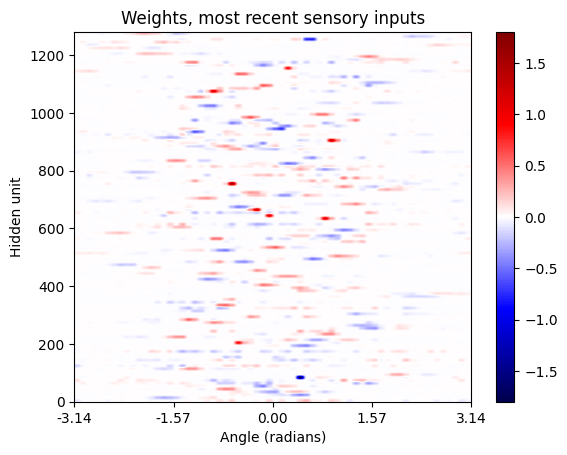

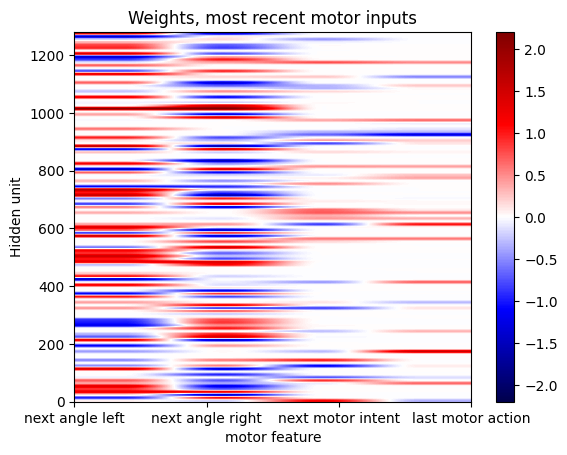

Text(0.5, 1.0, 'Turn VS forwards intents')

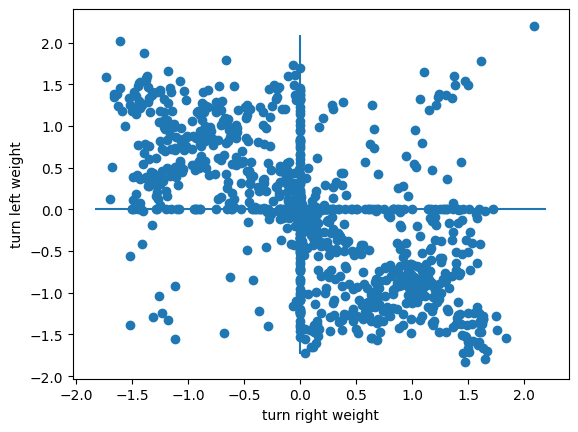

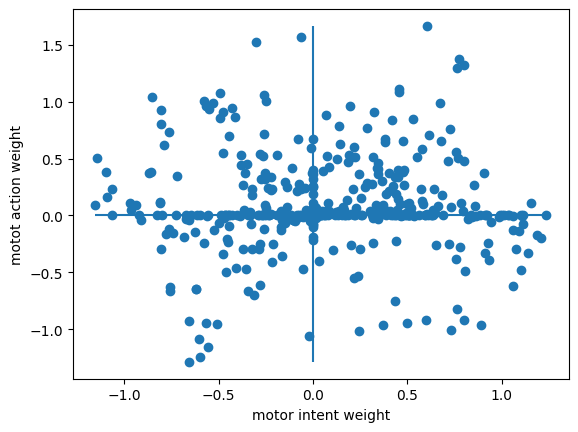

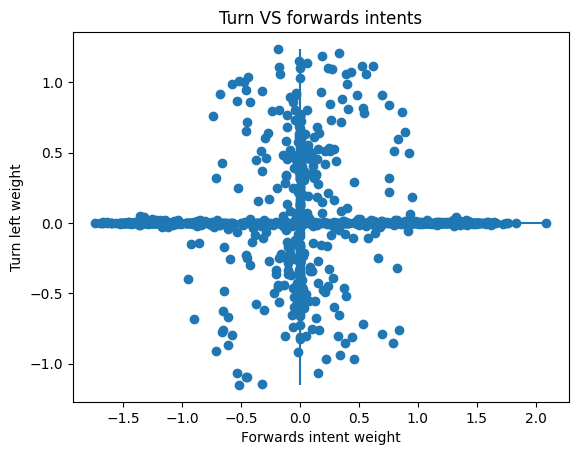

In [110]:
# Assuming 'weights_plot' is defined elsewhere in your code and is a 2D array.
plt.figure()
vmax = np.max(abs(weights_plot))
vmin = -vmax
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

plt.imshow(weights_plot.transpose()[:128,:],cmap=cmap, aspect='auto', extent=[-np.pi, np.pi, 0, weights_plot.shape[1]],norm=norm)
plt.colorbar()
plt.xlabel('Angle (radians)')
plt.ylabel('Hidden unit')
plt.title('Weights, most recent sensory inputs')
plt.xticks(np.linspace(-np.pi, np.pi, 5), [f'{x:.2f}' for x in np.linspace(-np.pi, np.pi, 5)])
plt.show()


# Assuming 'weights_plot' is defined elsewhere in your code and is a 2D array.
m_weights_plot = final_motor_command_weights.cpu().detach().numpy()
m_weights_plot = np.transpose(m_weights_plot)
plt.figure()
vmax = np.max(abs(m_weights_plot))
vmin = -vmax
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

plt.imshow(m_weights_plot.transpose()[:128,:],cmap=cmap, aspect='auto', extent=[0, 3, 0, m_weights_plot.shape[1]],norm=norm)
plt.colorbar()
plt.xlabel('motor feature')
plt.ylabel('Hidden unit')
plt.title('Weights, most recent motor inputs')
plt.xticks([0,1,2,3], ['next angle left','next angle right','next motor intent','last motor action'])
plt.show()



plt.figure()
plt.scatter(m_weights_plot.transpose()[:,0],m_weights_plot.transpose()[:,1])
plt.hlines(0,min(m_weights_plot.transpose()[:,1]),max(m_weights_plot.transpose()[:,1]))
plt.vlines(0,min(m_weights_plot.transpose()[:,0]),max(m_weights_plot.transpose()[:,0]))
plt.xlabel('turn right weight')
plt.ylabel('turn left weight')

plt.figure()
plt.scatter(m_weights_plot.transpose()[:,2],m_weights_plot.transpose()[:,3])
plt.hlines(0,min(m_weights_plot.transpose()[:,2]),max(m_weights_plot.transpose()[:,2]))
plt.vlines(0,min(m_weights_plot.transpose()[:,3]),max(m_weights_plot.transpose()[:,3]))
plt.xlabel('motor intent weight')
plt.ylabel('motot action weight')

plt.figure()
plt.scatter(m_weights_plot.transpose()[:,0],m_weights_plot.transpose()[:,2])
plt.hlines(0,min(m_weights_plot.transpose()[:,0]),max(m_weights_plot.transpose()[:,0]))
plt.vlines(0,min(m_weights_plot.transpose()[:,2]),max(m_weights_plot.transpose()[:,2]))
plt.ylabel('Turn left weight')
plt.xlabel('Forwards intent weight')
plt.title('Turn VS forwards intents')

In [161]:
plt.figure(figsize=(6, 3))
meaned_response = torch.mean(hidden_weights,0).view(T_test-1,N_sensors+4 ).cpu()
plt.imshow(meaned_response)
plt.title('mean receptive field feed_forward')
plt.ylabel('time'), vmin=vmin, vmax=vmax
plt.xlabel('feature sensor, motor')
plt.figure(figsize=(6,3))
std_response = torch.var(hidden_weights,0).view(T_test-1,N_sensors+4 ).cpu()
plt.imshow(std_response)
plt.title('variance receptive field feed_forward')
plt.ylabel('time')
plt.xlabel('feature sensor, motor')

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (857981955.py, line 5)

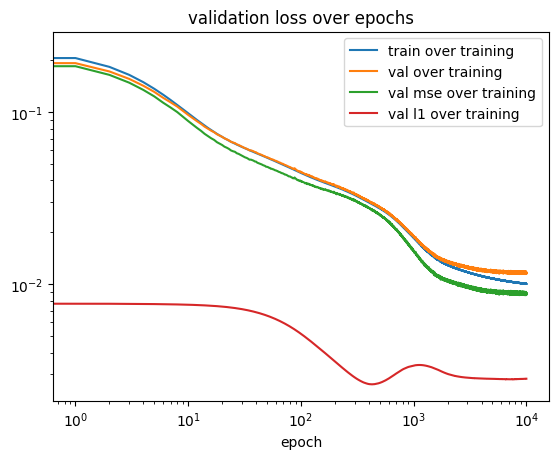

In [6]:
import matplotlib.pyplot as plt
plt.plot(train_loss_arr,label='train over training')
plt.plot(val_loss_arr, label='val over training')
plt.plot(val_loss_mse_arr, label='val mse over training')
plt.plot(val_loss_l1_arr, label='val l1 over training')
plt.title('validation loss over epochs')
plt.xlabel('epoch')
plt.yscale('log') 
plt.xscale('log')
plt.legend()

In [ ]:
# import plot_sim

# maze_map = plot_sim.make_maze_map('leaf.jpg', 1000, 1000)
# plot_sim.subject_animation(sensor_recording,angle_left_recording-angle_right_recording,\
#                            step_intent_recording, step_action_recording, position_recording, maze_map)

ang = torch.rand(N_trials)*2*np.pi - np.pi
print(ang)

tensor([ 2.0657, -1.3171, -2.9099, -0.8439, -2.0437, -1.5232,  1.7493, -1.4423,
         0.5983,  0.2510,  0.2774, -2.5838,  0.2350,  1.8771,  1.8666, -2.0568,
        -1.9940, -1.2977, -1.6077,  2.5077, -1.8889, -1.5088,  2.2933,  1.6599,
        -2.4582,  1.0998, -0.7660, -1.5316,  1.5515,  1.6463,  2.7132,  1.7853,
         2.1561, -0.5210,  1.5933,  0.7280,  1.2456, -1.6342, -2.6530, -1.3791,
        -0.9807, -2.3406, -0.3853, -0.0292,  1.9698, -2.5971,  1.7506, -2.3555,
         2.3597, -0.5950])


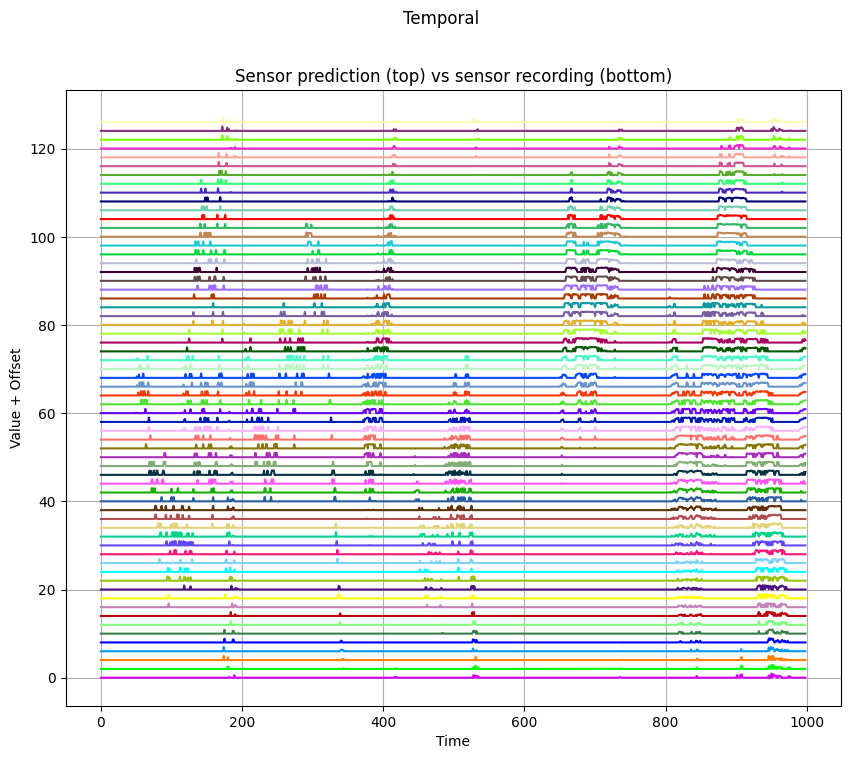

In [ ]:

np.random.seed(0)  # For reproducibility
data1 = sensor_recording[:,:,0]
import distinctipy
colors = distinctipy.get_colors(N_sensors)
#data2 = true_sensor

# Plotting
plt.figure(figsize=(10, 8))
time = np.arange(sensor_recording.shape[1])
for i in range(sensor_recording.shape[0]):
    plt.plot(time, data1[i, :] + i*2, color=colors[i], label=f'Trace {i+1} from prediction')  # Offset by i
    #plt.plot(time, data2[:, i] + i*2-1, color=colors[i], linestyle='-', label=f'Trace {i+1} from recording')  # Offset by i

plt.xlabel('Time')
plt.ylabel('Value + Offset')
plt.title('Sensor prediction (top) vs sensor recording (bottom)')
plt.suptitle('Temporal')
plt.grid(True)
plt.show()